# Suggesting Affordable yet Safe Housing in Seattle, WA

# Introduction/Business Problem

This report is for the final course of the IBM Advanced Data Science Specialization hosted on Coursera platform. The project allows learners to be as creative as they want and come up with an idea to leverage the location data available via FourSquare API to compare neighborhoods of a city of choice, come up with a problem which can be solved using that data.

In our problem statement, we have a group of athletes who are planning to live in Seattle for several weeks. They would need to find several flats, so it's desirable that they are located nearby to make the collective work-outs easier. Additional preferences include presence of a park nearby and low criminality in that district because they are planning to be outside very often (jogging in the evenings, etc). Also, the apartments should be affordable, but the factor of low criminality is valued higher by our clients.

The target audience for this report are:
- potential buyers, who can roughly estimate which neighborhoods are more desired (and the models used for analysis should be easily adjustable),
- real estate builders and planners who can decide what kind of neighborhoods are more attractive on the market to maximize selling price of newly built flats,
- and of course, to this course's instructors and learners who will grade my project,
- anyone who is curious how Python can be applied to easily crawl web pages; parse CSV or JSON files; create powerful visualizations of data as scatter plots, heat maps, density plots using matplotlib, seaborn and map visualizations using Folium; process data using lists, dictionaries, pandas DataFrames.

All the code with data analysis is available on my Github page: https://github.com/YuryChebiryak/IBM_advanced_data_science



## Data

Seattle city neighborhoods were chosen as the observation target due to following reasons:

there is a lot of statistical data freely available for USA,
diversity of neighborhoods: Seattle is a rather large city with very different districts,
availability of geolocation data to allow for visualizations on a map.
For the data acquisition part, we use this Wikipedia article to find out Seattle's district names and coordinates. For most of them, we couldn't find any additional information like population size. We get the population information from the portal 'Find My Seattle'. Crime data is available from official sources of City of Seattle. For prices of flats we use data set provided by Airbnb on Kaggle portal. To locate parks nearby flats, we access FourSquare API.

### Data acquisition part1: Obtain list of  districts and their coordinates

In [1]:
import requests
import pandas as pd
from lxml import html
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
sns.set(rc={'figure.figsize' : (25, 15)})

In [3]:
url = "https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Seattle"
page = requests.get(url)
print(page.text[:500])

<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>Category:Neighborhoods in Seattle - Wikipedia</title>
<script>document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );</script>
<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"Category","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":14,"wgPageName":"Category:Neighborhoods_in_Se


In [4]:
webpage = html.fromstring(page.content)

lst = webpage.xpath('//li/a/@href')
print(lst[0:10])

['/wiki/List_of_neighborhoods_in_Seattle', '/wiki/Adams,_Seattle', '/wiki/Alki_Point,_Seattle', '/wiki/Arbor_Heights,_Seattle', '/wiki/Atlantic,_Seattle', '/wiki/The_Ave', '/wiki/Ballard,_Seattle', '/wiki/Beacon_Hill,_Seattle', '/wiki/Belltown,_Seattle', '/wiki/Bitter_Lake,_Seattle']


Need to skip the first item and all items after the last district (Yesler Terrace):

In [5]:
lst=lst[1:lst.index('/wiki/Yesler_Terrace,_Seattle') + 1]

In [6]:
lst[0:7]

['/wiki/Adams,_Seattle',
 '/wiki/Alki_Point,_Seattle',
 '/wiki/Arbor_Heights,_Seattle',
 '/wiki/Atlantic,_Seattle',
 '/wiki/The_Ave',
 '/wiki/Ballard,_Seattle',
 '/wiki/Beacon_Hill,_Seattle']

In [7]:
lst[-5:]

['/wiki/Westlake,_Seattle',
 '/wiki/Westwood,_Seattle',
 '/wiki/Whittier_Heights,_Seattle',
 '/wiki/Windermere,_Seattle',
 '/wiki/Yesler_Terrace,_Seattle']

 Apparently the was a typo on the Wikipedia page and only 105 districts are listed.
 Now we need to follow each of these links and obtain coordinates and the name of a district

In [8]:
names = []
long = []
latt = []

for url in lst:
    full_url = 'https://en.wikipedia.org/' + url
    page = requests.get(full_url)
    webpage = html.fromstring(page.content)
    name = webpage.xpath('//title')[0].text
    name = name[:name.index(' - Wikipedia')]
    if name.find(', Seattle') > 0:
        name = name[:name.index(', Seattle')]
    coords = webpage.xpath('//span[@class="geo"]')
    if len(coords): # unfortunatelly, for some districts there are no coordinates on the wiki
        coords = coords[0].text
        latt.append(float(coords[:coords.index(';')]))
        long.append(float(coords[coords.index(';')+2:]))
        names.append(name)
print(names, latt, long)

['Adams', 'Alki Point', 'Arbor Heights', 'Atlantic', 'The Ave', 'Ballard', 'Beacon Hill', 'Belltown', 'Bitter Lake', 'Blue Ridge', 'Briarcliff', 'Brighton', 'Broadmoor', 'Broadview', 'Bryant', 'Capitol Hill (Seattle)', 'Cascade', 'Cedar Park', 'Central District', 'Central Waterfront', 'Cherry Hill', 'Chinatown–International District', 'Columbia City', 'Crown Hill', 'Delridge', 'Denny Triangle', 'Denny-Blaine', 'Downtown Seattle', 'Dunlap', 'Eastlake', 'Fairmount Park', 'Fauntleroy', 'First Hill', 'Fremont', 'Gatewood', 'Genesee', 'Georgetown', 'Green Lake', 'Greenwood', 'Haller Lake', 'Harbor Island', 'Harvard-Belmont Landmark District', 'Hawthorne Hills', 'Hillman City', 'Industrial District', 'Interbay', 'Lake City', 'Laurelhurst', 'Lawton Park', 'Leschi', 'Licton Springs', 'Lower Queen Anne', 'Loyal Heights', 'Madison Park', 'Madison Valley', 'Madrona', 'Magnolia', 'Maple Leaf', 'Matthews Beach', 'Meadowbrook', 'Meridian', 'Montlake', 'Mount Baker', 'NewHolly', 'North Admiral', 'Nor

In [9]:
districts_coords = pd.DataFrame({"Neighborhood" : names, "Latitude" : latt, "Longitude" : long})
print(districts_coords.head())

    Neighborhood   Latitude   Longitude
0          Adams  47.670132 -122.388729
1     Alki Point  47.576271 -122.420818
2  Arbor Heights  47.509550 -122.378190
3       Atlantic  47.596940 -122.308060
4        The Ave  47.661000 -122.313000


Let's double check that the data looks reasonable.

In [10]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.') 

Libraries imported.


In [11]:
address = 'Seattle, SA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
seattle_latitude = location.latitude
seattle_longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(seattle_latitude, seattle_longitude))

map_seattle = folium.Map(location=[seattle_latitude, seattle_longitude], zoom_start=12)
map_seattle

The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


In [12]:
# add markers to map
for lat, lng, neighborhood in zip(districts_coords['Latitude'], districts_coords['Longitude'], districts_coords['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle) 

In [13]:
map_seattle

Save the data for later use

In [14]:
#df.to_csv("SeattleDistricts.csv")

#project.save_data("SeattleDistricts.csv", df.to_csv(), overwrite=True)
districts_coords.to_csv("SeattleDistricts.csv")

### Data acquisition part 2: Obtain crime data for Seattle 
    Our source of crime data for Seattle is https://data.seattle.gov/Public-Safety/Crime-Data/4fs7-3vj5


In [15]:
import requests
import pandas as pd
from lxml import html
import json

In [16]:
url = "https://data.seattle.gov/resource/4fs7-3vj5.json"
page = requests.get(url)

In [17]:
j = json.loads(page.text)
print(j[0:5])

[{'beat': 'R3', 'crime_description': 'BURGLARY-FORCE-RES', 'crime_subcategory': 'BURGLARY-RESIDENTIAL', 'go_number': '1975000079415', 'neighborhood': 'LAKEWOOD/SEWARD PARK', 'occ_datetime': '1975-12-16T00:00:00.000', 'occ_time': '900', 'precinct': 'SOUTH', 'reported_date': '1975-12-16T00:00:00.000', 'reported_time': '1500', 'sector': 'R'}, {'crime_description': 'SEXOFF-INDECENT LIBERTIES', 'crime_subcategory': 'SEX OFFENSE-OTHER', 'go_number': '1976000069169', 'neighborhood': 'UNKNOWN', 'occ_datetime': '1976-01-01T00:00:00.000', 'occ_time': '1', 'precinct': 'UNKNOWN', 'reported_date': '1976-01-31T00:00:00.000', 'reported_time': '2359'}, {'beat': 'G2', 'crime_description': 'THEFT-CARPROWL', 'crime_subcategory': 'CAR PROWL', 'go_number': '1979000049118', 'neighborhood': 'CENTRAL AREA/SQUIRE PARK', 'occ_datetime': '1979-01-28T00:00:00.000', 'occ_time': '1600', 'precinct': 'EAST', 'reported_date': '1979-02-09T00:00:00.000', 'reported_time': '1430', 'sector': 'G'}, {'beat': 'S2', 'crime_des

In [18]:
len(j)

1000

So, apparently, when using JSON API for this data, only 1000 crimes can be obtained. That's not enough for our needs.

Therefore, we have downloaded the data into CSV format and load them from IBM cloud directly into a pandas dataframe

In [19]:
import types
import pandas as pd
#from botocore.client import Config
#import ibm_boto3

#def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
#client_a0ef65717c914cf4b77b78d5d1052f79 = ibm_boto3.client(service_name='s3',
#    ibm_api_key_id='-8mOlYnCyIi-zvK1ehx_Uk2Razz26Bc66BF5k2KPO7kE',
#    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
#    config=Config(signature_version='oauth'),
#    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

#body = client_a0ef65717c914cf4b77b78d5d1052f79.get_object(Bucket='courseracapstoneyurychebiryak-donotdelete-pr-szy93cgkynqru9',Key='Crime_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

#crimes = pd.read_csv(body)
crimes = pd.read_csv('Crime_Data.csv')
crimes.tail()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
514651,201900009949,01/08/2019,900.0,01/08/2019,1054.0,THEFT-ALL OTHER,THEFT-OTH,WEST,M,M2,DOWNTOWN COMMERCIAL
514652,201900009960,01/07/2019,1200.0,01/08/2019,1200.0,THEFT-ALL OTHER,THEFT-OTH,NORTH,U,U1,UNIVERSITY
514653,201900009966,01/08/2019,1051.0,01/08/2019,1051.0,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-BODYFORCE,WEST,M,M2,DOWNTOWN COMMERCIAL
514654,201900009967,01/08/2019,1050.0,01/08/2019,1052.0,THEFT-SHOPLIFT,THEFT-SHOPLIFT,NORTH,B,B1,BALLARD SOUTH
514655,201900009989,01/08/2019,1106.0,01/08/2019,1106.0,THEFT-SHOPLIFT,THEFT-SHOPLIFT,EAST,C,C1,MILLER PARK


In [20]:
crimes.shape

(514656, 11)

In [21]:
crimes.columns

Index(['Report Number', 'Occurred Date', 'Occurred Time', 'Reported Date',
       'Reported Time', 'Crime Subcategory', 'Primary Offense Description',
       'Precinct', 'Sector', 'Beat', 'Neighborhood'],
      dtype='object')

After a discussion with our client, she told us to filter out some crime categories.

In [22]:
crimes.drop(crimes[crimes["Crime Subcategory"] == "ARSON"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "CAR PROWL"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "DUI"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "FAMILY OFFENSE-NONVIOLENT"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "GAMBLE"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "LIQUOR LAW VIOLATION"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "LOITERING"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "MOTOR VEHICLE THEFT"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "PORNOGRAPHY"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "PROSTITUTION"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "ROBBERY-STREET"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "THEFT-SHOPLIFT"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "THEFT-BICYCLE"].index, inplace=True)
crimes.drop(crimes[crimes["Crime Subcategory"] == "TRESPASS"].index, inplace=True)

In [23]:
crimes.shape

(212275, 11)

Success! Over half a million crimes have been loaded into the dataframe.
Upon investigation of data, we realize that for some crimes neighborhood isn't just a single name, but a union of two or three districts (probably simply due to having a single police dept accross these districts). We'd need to normalize this at a later stage.



### Data acquisition part 3: District populations

Having raw crime data without consideration of district's size or population makes the data biased. We will need to normalize the crime rate by the population of each district.
To that end, we have entered the data from https://findmyseattle.com/home by hand into a CSV file (couldn't process them automatically, because the website is hard to webcrawl)


In [24]:
# @hidden_cell
#body = client_a0ef65717c914cf4b77b78d5d1052f79.get_object(Bucket='courseracapstoneyurychebiryak-donotdelete-pr-szy93cgkynqru9',Key='SeattlePopulationPricesByDistrict.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

#population = pd.read_csv(body)
population = pd.read_csv('SeattlePopulationPricesByDistrict.csv')
population.head()

,Neighborhood,Est. Population,Median Rental Price
0,Ballard,49780,2548
1,Beacon Hill,36358,2365
2,Bellevue,150305,2729
3,Bothell,27262,2378
4,Broadview,17301,2654


In [25]:
population["Neighborhood"].values

array(['Ballard', 'Beacon Hill', 'Bellevue', 'Bothell', 'Broadview',
       'Burien', 'Capitol Hill', 'Central District',
       'Chinatown - Intl. District', 'Columbia City/Brighton', 'Downtown',
       'Eastlake', 'Fremont', 'Georgetown/SODO', 'Green Lake/Greenwood',
       'Kenmore', 'Kirkland', 'Lake City', 'Lake Forest Park',
       'Madison Park', 'Magnolia/Interbay', 'Mercer Island',
       'Mount Baker', 'Northeast Seattle', 'Northgate', 'Phinney Ridge',
       'Pioneer Square', 'Queen Anne', 'Rainier Beach', 'Redmond',
       'Renton', 'Shoreline', 'South Lake Union', 'Tukwila',
       'University District', 'Wallingford', 'West Seattle', 'Westlake',
       'White Center', 'Woodinville'], dtype=object)

In [26]:
crimes["Neighborhood"].unique()

array(['LAKEWOOD/SEWARD PARK', 'UNKNOWN', 'BRIGHTON/DUNLAP',
       'ROXHILL/WESTWOOD/ARBOR HEIGHTS', 'CLAREMONT/RAINIER VISTA',
       'HIGH POINT', 'DOWNTOWN COMMERCIAL', 'CENTRAL AREA/SQUIRE PARK',
       'JUDKINS PARK/NORTH BEACON HILL', 'NORTH ADMIRAL', 'MILLER PARK',
       'HILLMAN CITY', 'MORGAN', 'SOUTH PARK', 'MONTLAKE/PORTAGE BAY',
       'CAPITOL HILL', 'NORTHGATE', 'NEW HOLLY', 'RAINIER BEACH',
       'QUEEN ANNE', 'RAINIER VIEW', 'BELLTOWN', 'ROOSEVELT/RAVENNA',
       'SODO', 'PIONEER SQUARE', 'GREENWOOD', 'GEORGETOWN',
       'SOUTH DELRIDGE', 'HIGHLAND PARK', 'FIRST HILL', 'LAKECITY',
       'NORTH BEACON HILL', 'BITTERLAKE', 'MOUNT BAKER', 'MADRONA/LESCHI',
       'SLU/CASCADE', 'COLUMBIA CITY', 'NORTH DELRIDGE', 'BALLARD NORTH',
       'BALLARD SOUTH', 'PHINNEY RIDGE', 'UNIVERSITY', 'MID BEACON HILL',
       'WALLINGFORD', 'SOUTH BEACON HILL',
       'CHINATOWN/INTERNATIONAL DISTRICT', 'EASTLAKE - WEST', 'FREMONT',
       'ALASKA JUNCTION', 'SANDPOINT', 'MAGNOLIA', '

As we can see, we have discrepancies in the names of districts. 
We would need to capitalize the names in the same way, and in crime data combine things like 'SOUTH BEACON HILL' and 'NORTH BEACON HILL' and 'MID BEACON HILL' into just 'Beacon Hill', 

To that end, we will replace all occurences of 'SOUTH BEACON HILL' with simply 'Beacon Hill' and similar.


In [27]:
population['Neighborhood'] = population['Neighborhood'].str.upper()

In [28]:
set(crimes["Neighborhood"].unique()).intersection(set(population["Neighborhood"]))

{'CAPITOL HILL',
 'FREMONT',
 'MADISON PARK',
 'MOUNT BAKER',
 'NORTHGATE',
 'PHINNEY RIDGE',
 'PIONEER SQUARE',
 'QUEEN ANNE',
 'RAINIER BEACH',
 'WALLINGFORD'}

So far, our data agrees only on a handful of districts' titles.
Here are the differences:

In [29]:
print(set(crimes["Neighborhood"].unique()).symmetric_difference(set(population["Neighborhood"])))

{'NORTH ADMIRAL', 'SODO', 'SANDPOINT', 'DOWNTOWN COMMERCIAL', 'NORTHEAST SEATTLE', 'MONTLAKE/PORTAGE BAY', 'RAINIER VIEW', 'MERCER ISLAND', 'CHINATOWN - INTL. DISTRICT', 'MILLER PARK', 'SOUTH PARK', 'WHITE CENTER', 'MAGNOLIA', 'COLUMBIA CITY', 'BALLARD', 'FAUNTLEROY SW', 'LAKECITY', 'EASTLAKE', 'BEACON HILL', 'JUDKINS PARK/NORTH BEACON HILL', 'FIRST HILL', 'TUKWILA', 'UNIVERSITY DISTRICT', 'NEW HOLLY', 'BRIGHTON/DUNLAP', 'COMMERCIAL DUWAMISH', 'BALLARD SOUTH', 'MORGAN', 'HIGH POINT', 'LAKE CITY', 'ROOSEVELT/RAVENNA', 'KENMORE', 'MADRONA/LESCHI', 'WEST SEATTLE', 'REDMOND', 'UNIVERSITY', 'BITTERLAKE', 'ALKI', 'BELLEVUE', 'BALLARD NORTH', 'ROXHILL/WESTWOOD/ARBOR HEIGHTS', 'CHINATOWN/INTERNATIONAL DISTRICT', 'DOWNTOWN', 'EASTLAKE - WEST', 'MID BEACON HILL', 'BROADVIEW', 'UNKNOWN', 'MAGNOLIA/INTERBAY', 'COMMERCIAL HARBOR ISLAND', 'NORTH DELRIDGE', 'PIGEON POINT', 'SOUTH LAKE UNION', 'SOUTH DELRIDGE', 'HILLMAN CITY', 'GREENWOOD', 'EASTLAKE - EAST', 'GEORGETOWN', 'GREEN LAKE/GREENWOOD', 'GEOR

In [30]:
crimes.loc[crimes["Neighborhood"] == 'ALASKA JUNCTION', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'ALKI', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'BALLARD NORTH', 'Neighborhood'] = "BALLARD"
crimes.loc[crimes["Neighborhood"] == 'BALLARD SOUTH', 'Neighborhood'] = "BALLARD"
crimes.loc[crimes["Neighborhood"] == 'BELLTOWN', 'Neighborhood'] = "DOWNTOWN"
crimes.loc[crimes["Neighborhood"] == 'BITTERLAKE', 'Neighborhood'] = "BROADVIEW"
crimes.loc[crimes["Neighborhood"] == 'BRIGHTON/DUNLAP', 'Neighborhood'] = "COLUMBIA CITY/BRIGHTON"
crimes.loc[crimes["Neighborhood"] == 'CAPITOL HILL', 'Neighborhood'] = "CAPITOL HILL"
crimes.loc[crimes["Neighborhood"] == 'CENTRAL AREA/SQUIRE PARK', 'Neighborhood'] = "CENTRAL DISTRICT"
crimes.loc[crimes["Neighborhood"] == 'CHINATOWN/INTERNATIONAL DISTRICT', 'Neighborhood'] = "CHINATOWN - INTL. DISTRICT"
crimes.loc[crimes["Neighborhood"] == 'CLAREMONT/RAINIER VISTA', 'Neighborhood'] = "MOUNT BAKER"
crimes.loc[crimes["Neighborhood"] == 'COLUMBIA CITY', 'Neighborhood'] = "COLUMBIA CITY/BRIGHTON"
crimes.loc[crimes["Neighborhood"] == 'COMMERCIAL DUWAMISH', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'COMMERCIAL HARBOR ISLAND', 'Neighborhood'] = "GEORGETOWN/SODO"
crimes.loc[crimes["Neighborhood"] == 'DOWNTOWN COMMERCIAL', 'Neighborhood'] = "DOWNTOWN"
crimes.loc[crimes["Neighborhood"] == 'EASTLAKE - EAST', 'Neighborhood'] = "EASTLAKE"
crimes.loc[crimes["Neighborhood"] == 'EASTLAKE - WEST', 'Neighborhood'] = "EASTLAKE"
crimes.loc[crimes["Neighborhood"] == 'FAUNTLEROY SW', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'FIRST HILL', 'Neighborhood'] = "DOWNTOWN"
crimes.loc[crimes["Neighborhood"] == 'FREMONT', 'Neighborhood'] = "FREMONT"
crimes.loc[crimes["Neighborhood"] == 'GENESEE', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'GEORGETOWN', 'Neighborhood'] = "GEORGETOWN/SODO"
crimes.loc[crimes["Neighborhood"] == 'GREENWOOD', 'Neighborhood'] = "GREEN LAKE/GREENWOOD"
crimes.loc[crimes["Neighborhood"] == 'HIGH POINT', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'HIGHLAND PARK', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'HILLMAN CITY', 'Neighborhood'] = "COLUMBIA CITY/BRIGHTON"
crimes.loc[crimes["Neighborhood"] == 'JUDKINS PARK/NORTH BEACON HILL', 'Neighborhood'] = "BEACON HILL"
crimes.loc[crimes["Neighborhood"] == 'LAKECITY', 'Neighborhood'] = "LAKE CITY"
crimes.loc[crimes["Neighborhood"] == 'LAKEWOOD/SEWARD PARK', 'Neighborhood'] = "COLUMBIA CITY/BRIGHTON"
crimes.loc[crimes["Neighborhood"] == 'MADISON PARK', 'Neighborhood'] = "MADISON PARK"
crimes.loc[crimes["Neighborhood"] == 'MADRONA/LESCHI', 'Neighborhood'] = "CENTRAL DISTRICT"
crimes.loc[crimes["Neighborhood"] == 'MAGNOLIA', 'Neighborhood'] = "MAGNOLIA/INTERBAY"
crimes.loc[crimes["Neighborhood"] == 'MID BEACON HILL', 'Neighborhood'] = "BEACON HILL"
crimes.loc[crimes["Neighborhood"] == 'MILLER PARK', 'Neighborhood'] = "CAPITOL HILL"
crimes.loc[crimes["Neighborhood"] == 'MONTLAKE/PORTAGE BAY', 'Neighborhood'] = "CAPITOL HILL"
crimes.loc[crimes["Neighborhood"] == 'MORGAN', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'MOUNT BAKER', 'Neighborhood'] = "MOUNT BAKER"
crimes.loc[crimes["Neighborhood"] == 'NEW HOLLY', 'Neighborhood'] = "BEACON HILL"
crimes.loc[crimes["Neighborhood"] == 'NORTH ADMIRAL', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'NORTH BEACON HILL', 'Neighborhood'] = "BEACON HILL"
crimes.loc[crimes["Neighborhood"] == 'NORTH DELRIDGE', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'NORTHGATE', 'Neighborhood'] = "NORTHGATE"
crimes.loc[crimes["Neighborhood"] == 'PHINNEY RIDGE', 'Neighborhood'] = "PHINNEY RIDGE"
crimes.loc[crimes["Neighborhood"] == 'PIGEON POINT', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'PIONEER SQUARE', 'Neighborhood'] = "PIONEER SQUARE"
crimes.loc[crimes["Neighborhood"] == 'QUEEN ANNE', 'Neighborhood'] = "QUEEN ANNE"
crimes.loc[crimes["Neighborhood"] == 'RAINIER BEACH', 'Neighborhood'] = "RAINIER BEACH"
crimes.loc[crimes["Neighborhood"] == 'RAINIER VIEW', 'Neighborhood'] = "RAINIER BEACH"
crimes.loc[crimes["Neighborhood"] == 'ROOSEVELT/RAVENNA', 'Neighborhood'] = "UNIVERSITY DISTRICT"
crimes.loc[crimes["Neighborhood"] == 'ROXHILL/WESTWOOD/ARBOR HEIGHTS', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'SANDPOINT', 'Neighborhood'] = "NORTHEAST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'SLU/CASCADE', 'Neighborhood'] = "SOUTH LAKE UNION"
crimes.loc[crimes["Neighborhood"] == 'SODO', 'Neighborhood'] = "GEORGETOWN/SODO"
crimes.loc[crimes["Neighborhood"] == 'SOUTH BEACON HILL', 'Neighborhood'] = "BEACON HILL"
crimes.loc[crimes["Neighborhood"] == 'SOUTH DELRIDGE', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'SOUTH PARK', 'Neighborhood'] = "WEST SEATTLE"
crimes.loc[crimes["Neighborhood"] == 'UNIVERSITY', 'Neighborhood'] = "UNIVERSITY DISTRICT"
crimes.loc[crimes["Neighborhood"] == 'UNKNOWN', 'Neighborhood'] = "N/A"
crimes.loc[crimes["Neighborhood"] == 'WALLINGFORD', 'Neighborhood'] = "WALLINGFORD"
#let us drop the rows with unknown districts
crimes.drop(crimes[crimes["Neighborhood"] == "N/A"].index, inplace=True)

We investigate each of the districts from crime data set and try to figure out which district from population data set it belongs to using the extensive information from Wikipedia (https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle ) and also by looking at the map. 
Here is the resulting mapping:

It is of note, that some of the districts mentioned in the population data set weren't mapped to any in the crime data set. Namely,

In [31]:
print(set(population["Neighborhood"]).difference(set(crimes["Neighborhood"].unique())))

{'WHITE CENTER', 'WOODINVILLE', 'BELLEVUE', 'REDMOND', 'LAKE FOREST PARK', 'WESTLAKE', 'SHORELINE', 'KIRKLAND', 'BOTHELL', 'TUKWILA', 'BURIEN', 'RENTON', 'KENMORE', 'MERCER ISLAND'}


 For the most part, these are new districts of Seattle which aren't listed even on Wikipedia (or listed as separate towns) and it is fine to omit them in our analysis. 

In [32]:
population.drop(population[population["Neighborhood"] == "REDMOND"].index, inplace=True)
population.drop(population[population["Neighborhood"] == "WOODINVILLE"].index, inplace=True)
population.drop(population[population["Neighborhood"] == "BOTHELL"].index, inplace=True)
population.drop(population[population["Neighborhood"] == "MERCER ISLAND"].index, inplace=True)
population.drop(population[population["Neighborhood"] == "KIRKLAND"].index, inplace=True)
population.drop(population[population["Neighborhood"] == "KENMORE"].index, inplace=True)
population.drop(population[population["Neighborhood"] == "LAKE FOREST PARK"].index, inplace=True)
population.drop(population[population["Neighborhood"] == "BELLEVUE"].index, inplace=True)
population.drop(population[population["Neighborhood"] == "BURIEN"].index, inplace=True)
population.drop(population[population["Neighborhood"] == "TUKWILA"].index, inplace=True)
population.drop(population[population["Neighborhood"] == "SHORELINE"].index, inplace=True)

However, we are unsure about Westlake: has it been attributed to Queen Anne district in the crime dataset or to South Lake Union? According to Wikipedia, its Lake Union, so lets add its population to the South Lake Union neighborhood and keep the median rental price untouched.

In [33]:
population.loc[population["Neighborhood"] == "SOUTH LAKE UNION"]["Est. Population"].iloc[0]

11434

In [34]:
population.loc[population["Neighborhood"] == "WESTLAKE"]["Est. Population"]

37    2483
Name: Est. Population, dtype: int64

In [35]:
population.loc[population["Neighborhood"] == "SOUTH LAKE UNION"]["Est. Population"].iloc[0] + population.loc[population["Neighborhood"] == "WESTLAKE"]["Est. Population"].iloc[0]

13917

In [36]:
population.loc[population["Neighborhood"] == "SOUTH LAKE UNION", "Est. Population"] = population.loc[population["Neighborhood"] == "SOUTH LAKE UNION"]["Est. Population"].iloc[0] + population.loc[population["Neighborhood"] == "WESTLAKE"]["Est. Population"].iloc[0]

In [37]:
population.loc[population["Neighborhood"] == "SOUTH LAKE UNION", "Est. Population"]

32    13917
Name: Est. Population, dtype: int64

In [38]:
population.drop(population[population["Neighborhood"] == "WESTLAKE"].index, inplace=True)

Same goes for Renton: it should be included inside of Capitol Hill district

In [39]:
population.loc[population["Neighborhood"] == "CAPITOL HILL", "Est. Population"] = population.loc[population["Neighborhood"] == "CAPITOL HILL"]["Est. Population"].iloc[0] + population.loc[population["Neighborhood"] == "RENTON"]["Est. Population"].iloc[0]
population.drop(population[population["Neighborhood"] == "RENTON"].index, inplace=True)

We don't know where to attribute the population of White Center. After some searching on the internet, we figure out the breakdown of districts into beats: http://spdblotter.seattle.gov/wp-content/uploads/2015/01/beat-map-2.png  and it's apparent that White Center is in Sectors F2 and F3.


<img src="http://spdblotter.seattle.gov/wp-content/uploads/2015/01/beat-map-2.png" width=400>Precincts of Seattle</img>

In [40]:
crimes["Beat"].unique()

array(['R3', 'S2', 'W3', 'R2', 'F1', 'K3', 'G2', 'W1', 'C2', 'F3', 'E1',
       'N3', 'S1', 'E3', 'S3', 'Q3', 'L1', 'M1', 'M3', 'E2', 'J3', 'O1',
       'D2', 'K2', 'J1', 'D1', 'O3', 'F2', 'R1', 'K1', 'W2', 'L2', 'N2',
       'C3', 'G3', 'G1', 'J2', 'B1', 'B2', 'U2', 'N1', 'U1', 'B3', 'C1',
       'D3', 'L3', 'M2', 'Q2', 'U3', 'Q1', 'O2'], dtype=object)

In [41]:
crimes[crimes["Beat"] == "F2"].head()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
64,20070000189584,05/12/2007,730.0,05/12/2007,730.0,AGGRAVATED ASSAULT,ASSLT-AGG-CHILD-BODYFORCE,SOUTHWEST,F,F2,WEST SEATTLE
98,20070000329837,08/11/2007,300.0,08/11/2007,559.0,RAPE,RAPE-STRONGARM,SOUTHWEST,F,F2,WEST SEATTLE
171,20070000506827,12/19/2007,1140.0,12/19/2007,1140.0,AGGRAVATED ASSAULT-DV,ASSLT-AGG-DV-BODYFORCE,SOUTHWEST,F,F2,WEST SEATTLE
625,20080000104391,03/20/2008,1800.0,03/21/2008,1614.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTHWEST,F,F2,WEST SEATTLE
993,20080000108278,03/17/2008,1.0,03/24/2008,1814.0,THEFT-ALL OTHER,THEFT-OTH,SOUTHWEST,F,F2,WEST SEATTLE


Thus, it has to be attributed to West Seattle district.

In [42]:
population.loc[population["Neighborhood"] == "WEST SEATTLE", "Est. Population"] = population.loc[population["Neighborhood"] == "WHITE CENTER"]["Est. Population"].iloc[0] + population.loc[population["Neighborhood"] == "WEST SEATTLE"]["Est. Population"].iloc[0]
population.drop(population[population["Neighborhood"] == "WHITE CENTER"].index, inplace=True)

Finally, there shouldn't be any differences in naming of districts between two sets

In [43]:
print(set(crimes["Neighborhood"].unique()).symmetric_difference(set(population["Neighborhood"])))

set()


In [44]:
crimes["Neighborhood"].unique().shape

(26,)

Having just a total number of crimes per district doesn't exactly reflect a good picture.
We would need to normalize this number by the number of citizens living in that neighborhood.
Also, we would like to see the dynamics of the values: have the crime situation worsened, improved or stayed the same?
To that end, let's first form histograms year-by-year for each district.

In [45]:
crimes.iloc[0]["Occurred Date"]

'12/16/1975'

Let's convert this string into a datetime object

In [46]:
from datetime import datetime

datetime_object = datetime.strptime(crimes.iloc[0]["Occurred Date"], '%m/%d/%Y')

datetime_object

datetime.datetime(1975, 12, 16, 0, 0)

In [47]:
crimes["Occurred Date"].astype(str)[:10]

0     12/16/1975
3     08/22/1981
4     02/14/1981
6     10/08/1993
7     06/08/1994
11    01/15/2001
14    12/28/2002
15    05/23/2004
16    06/06/2004
17    01/16/2004
Name: Occurred Date, dtype: object

Turns out, for some data points date is missing.

In [48]:
crimes.drop(crimes[crimes["Neighborhood"] == 'UNKNOWN'].index, inplace=True)
crimes.shape

(210386, 11)

In [49]:
crimes[0:10]

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
0,1975000079415,12/16/1975,900.0,12/16/1975,1500.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTH,R,R3,COLUMBIA CITY/BRIGHTON
3,19810000305573,08/22/1981,2029.0,08/22/1981,2030.0,HOMICIDE,HOMICIDE-PREMEDITATED-WEAPON,SOUTH,S,S2,COLUMBIA CITY/BRIGHTON
4,1981000076456,02/14/1981,2000.0,02/15/1981,435.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTHWEST,W,W3,WEST SEATTLE
6,19930000465323,10/08/1993,2213.0,10/08/1993,2213.0,HOMICIDE,HOMICIDE-PREMEDITATED-GUN,SOUTH,R,R2,MOUNT BAKER
7,19940000264046,06/08/1994,0.0,06/12/1994,844.0,THEFT-ALL OTHER,THEFT-OTH,SOUTHWEST,F,F1,WEST SEATTLE
11,2001000024668,01/15/2001,2310.0,01/15/2001,2310.0,HOMICIDE,HOMICIDE-PREMEDITATED-GUN,WEST,K,K3,DOWNTOWN
14,20020000579098,12/28/2002,253.0,12/28/2002,253.0,HOMICIDE,HOMICIDE-PREMEDITATED-GUN,EAST,G,G2,CENTRAL DISTRICT
15,20040000209455,05/23/2004,2345.0,05/24/2004,710.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,EAST,G,G2,BEACON HILL
16,20040000230336,06/06/2004,1945.0,06/06/2004,1948.0,AGGRAVATED ASSAULT-DV,ASSLT-AGG-DV-BODYFORCE,SOUTHWEST,W,W1,WEST SEATTLE
17,2004000023455,01/16/2004,2130.0,01/17/2004,1405.0,RAPE,RAPE-STRONGARM,EAST,C,C2,CAPITOL HILL


In [50]:
crimes["Occurred Date"] = crimes["Occurred Date"].astype(str)
crimes

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
0,1975000079415,12/16/1975,900.0,12/16/1975,1500.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTH,R,R3,COLUMBIA CITY/BRIGHTON
3,19810000305573,08/22/1981,2029.0,08/22/1981,2030.0,HOMICIDE,HOMICIDE-PREMEDITATED-WEAPON,SOUTH,S,S2,COLUMBIA CITY/BRIGHTON
4,1981000076456,02/14/1981,2000.0,02/15/1981,435.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTHWEST,W,W3,WEST SEATTLE
6,19930000465323,10/08/1993,2213.0,10/08/1993,2213.0,HOMICIDE,HOMICIDE-PREMEDITATED-GUN,SOUTH,R,R2,MOUNT BAKER
7,19940000264046,06/08/1994,0.0,06/12/1994,844.0,THEFT-ALL OTHER,THEFT-OTH,SOUTHWEST,F,F1,WEST SEATTLE
11,2001000024668,01/15/2001,2310.0,01/15/2001,2310.0,HOMICIDE,HOMICIDE-PREMEDITATED-GUN,WEST,K,K3,DOWNTOWN
14,20020000579098,12/28/2002,253.0,12/28/2002,253.0,HOMICIDE,HOMICIDE-PREMEDITATED-GUN,EAST,G,G2,CENTRAL DISTRICT
15,20040000209455,05/23/2004,2345.0,05/24/2004,710.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,EAST,G,G2,BEACON HILL
16,20040000230336,06/06/2004,1945.0,06/06/2004,1948.0,AGGRAVATED ASSAULT-DV,ASSLT-AGG-DV-BODYFORCE,SOUTHWEST,W,W1,WEST SEATTLE
17,2004000023455,01/16/2004,2130.0,01/17/2004,1405.0,RAPE,RAPE-STRONGARM,EAST,C,C2,CAPITOL HILL


In [51]:
# doesn't work: pd.to_datetime(df_data_2["Occurred Date"], '%m/%d/%Y')
crimes["Occurred Date"] = crimes["Occurred Date"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
crimes.head()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
0,1975000079415,1975-12-16,900.0,12/16/1975,1500.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTH,R,R3,COLUMBIA CITY/BRIGHTON
3,19810000305573,1981-08-22,2029.0,08/22/1981,2030.0,HOMICIDE,HOMICIDE-PREMEDITATED-WEAPON,SOUTH,S,S2,COLUMBIA CITY/BRIGHTON
4,1981000076456,1981-02-14,2000.0,02/15/1981,435.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTHWEST,W,W3,WEST SEATTLE
6,19930000465323,1993-10-08,2213.0,10/08/1993,2213.0,HOMICIDE,HOMICIDE-PREMEDITATED-GUN,SOUTH,R,R2,MOUNT BAKER
7,19940000264046,1994-06-08,0.0,06/12/1994,844.0,THEFT-ALL OTHER,THEFT-OTH,SOUTHWEST,F,F1,WEST SEATTLE


We introduce two new columns, so it's easier for us to aggregate the data on a monthly basis.

In [52]:
crimes["Occurred Year"] = crimes["Occurred Date"].dt.year
crimes["Occurred Month"] = crimes["Occurred Date"].dt.month
crimes["Occurred Day of Week"] = crimes["Occurred Date"].dt.dayofweek
crimes["Occurred Hour"] = crimes["Occurred Time"] / 100
crimes["Occurred Hour"] = crimes["Occurred Hour"].astype(int)

In [53]:
crimes["YearMonth"] = pd.to_datetime(pd.DataFrame({'year' : crimes["Occurred Date"].dt.year, 'month': crimes["Occurred Date"].dt.month, 'day': [ 1 for x in range(len(crimes.index))]}))
crimes.tail()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood,Occurred Year,Occurred Month,Occurred Day of Week,Occurred Hour,YearMonth
514647,201900009928,2019-01-03,1.0,01/08/2019,1028.0,THEFT-ALL OTHER,THEFT-OTH,EAST,C,C3,CENTRAL DISTRICT,2019,1,3,0,2019-01-01
514649,201900009945,2018-12-20,800.0,01/08/2019,1138.0,THEFT-ALL OTHER,THEFT-OTH,NORTH,N,N2,BROADVIEW,2018,12,3,8,2018-12-01
514651,201900009949,2019-01-08,900.0,01/08/2019,1054.0,THEFT-ALL OTHER,THEFT-OTH,WEST,M,M2,DOWNTOWN,2019,1,1,9,2019-01-01
514652,201900009960,2019-01-07,1200.0,01/08/2019,1200.0,THEFT-ALL OTHER,THEFT-OTH,NORTH,U,U1,UNIVERSITY DISTRICT,2019,1,0,12,2019-01-01
514653,201900009966,2019-01-08,1051.0,01/08/2019,1051.0,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-BODYFORCE,WEST,M,M2,DOWNTOWN,2019,1,1,10,2019-01-01


Data is in a good enough shape to be stored into CSV file.

In [54]:
#project.save_data("SeattleCrimePrepared.csv", crimes.to_csv(), overwrite=True)
crimes.to_csv("SeattleCrimePrepared.csv")

Let us concentrate our efforts on crimes of the past decade.

In [55]:
crimes = crimes[crimes["Occurred Year"] >= 2009]
crimes.tail()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood,Occurred Year,Occurred Month,Occurred Day of Week,Occurred Hour,YearMonth
514647,201900009928,2019-01-03,1.0,01/08/2019,1028.0,THEFT-ALL OTHER,THEFT-OTH,EAST,C,C3,CENTRAL DISTRICT,2019,1,3,0,2019-01-01
514649,201900009945,2018-12-20,800.0,01/08/2019,1138.0,THEFT-ALL OTHER,THEFT-OTH,NORTH,N,N2,BROADVIEW,2018,12,3,8,2018-12-01
514651,201900009949,2019-01-08,900.0,01/08/2019,1054.0,THEFT-ALL OTHER,THEFT-OTH,WEST,M,M2,DOWNTOWN,2019,1,1,9,2019-01-01
514652,201900009960,2019-01-07,1200.0,01/08/2019,1200.0,THEFT-ALL OTHER,THEFT-OTH,NORTH,U,U1,UNIVERSITY DISTRICT,2019,1,0,12,2019-01-01
514653,201900009966,2019-01-08,1051.0,01/08/2019,1051.0,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-BODYFORCE,WEST,M,M2,DOWNTOWN,2019,1,1,10,2019-01-01


Also, let's truncate the incomplete last month

In [56]:
crimes.drop(crimes[crimes['YearMonth'] == '2019-01-01'].index, inplace=True)
crimes.drop(crimes[crimes['YearMonth'] == '2019-02-01'].index, inplace=True)

crimes.tail()

E:\anaconda\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood,Occurred Year,Occurred Month,Occurred Day of Week,Occurred Hour,YearMonth
514550,20190000902144,2018-10-05,1410.0,02/25/2019,1421.0,THEFT-ALL OTHER,THEFT-OTH,SOUTHWEST,F,F3,WEST SEATTLE,2018,10,4,14,2018-10-01
514596,201900009183,2018-12-09,0.0,01/07/2019,1801.0,BURGLARY-RESIDENTIAL-SECURE PARKING,BURGLARY-SECURE PARKING-RES,EAST,E,E1,CAPITOL HILL,2018,12,6,0,2018-12-01
514630,201900009678,2018-12-23,600.0,01/08/2019,816.0,BURGLARY-COMMERCIAL,BURGLARY-FORCE-NONRES,NORTH,U,U3,UNIVERSITY DISTRICT,2018,12,6,6,2018-12-01
514641,201900009850,2018-12-31,938.0,01/08/2019,938.0,BURGLARY-COMMERCIAL,BURGLARY-FORCE-NONRES,WEST,D,D1,DOWNTOWN,2018,12,0,9,2018-12-01
514649,201900009945,2018-12-20,800.0,01/08/2019,1138.0,THEFT-ALL OTHER,THEFT-OTH,NORTH,N,N2,BROADVIEW,2018,12,3,8,2018-12-01


In [57]:
crimes['YearMonth'].unique()[-5:]

array(['2018-07-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [58]:
crimes_hour_day = crimes.groupby(["Occurred Day of Week", "Occurred Hour"], axis=0).count()

In [59]:
crimes_hour_day[:25]

Report Number  Occurred Date  \
Occurred Day of Week Occurred Hour                                 
0                    0                       1573           1573   
                     1                        722            722   
                     2                        610            610   
                     3                        504            504   
                     4                        491            491   
                     5                        439            439   
                     6                        508            508   
                     7                        796            796   
                     8                       1185           1185   
                     9                       1117           1117   
                     10                      1175           1175   
                     11                      1174           1174   
                     12                      1889           1889   
                     13                      1379           1379   
                     14                      1367           1367   
                     15                      1504           1504   
                     16                      1497           1497   
                     17                      1496           1496   
                     18                      1445           1445   
                     19                      1251           1251   
                     20                      1336           1336   
                     21                      1194           1194   
                     22                      1088           1088   
                     23                       983            983   
1                    0                       1525           1525   

                                    Occurred Time  Reported Date  \
Occurred Day of Week Occurred Hour                                 
0                    0                       1573           1573   
                     1                        722            722   
                     2                        610            610   
                     3                        504            504   
                     4                        491            491   
                     5                        439            439   
                     6                        508            508   
                     7                        796            796   
                     8                       1185           1185   
                     9                       1117           1117   
                     10                      1175           1175   
                     11                      1174           1174   
                     12                      1889           1889   
                     13                      1379           1379   
                     14                      1367           1367   
                     15                      1504           1504   
                     16                      1497           1497   
                     17                      1496           1496   
                     18                      1445           1445   
                     19                      1251           1251   
                     20                      1336           1336   
                     21                      1194           1194   
                     22                      1088           1088   
                     23                       983            983   
1                    0                       1525           1525   

                                    Reported Time  Crime Subcategory  \
Occurred Day of Week Occurred Hour                                     
0                    0                       1573               1573   
                     1                        722                722   
                     2                        610                610   
  

In [60]:
crimes_hour_day['Report Number']

Occurred Day of Week  Occurred Hour
0                     0                1573
                      1                 722
                      2                 610
                      3                 504
                      4                 491
                      5                 439
                      6                 508
                      7                 796
                      8                1185
                      9                1117
                      10               1175
                      11               1174
                      12               1889
                      13               1379
                      14               1367
                      15               1504
                      16               1497
                      17               1496
                      18               1445
                      19               1251
                      20               1336
                      21               1

In [61]:
crimes_heatmap = crimes_hour_day['Report Number'].unstack().values[:, :].transpose() #np.newaxis]
crimes_heatmap

array([[1573, 1525, 1535, 1592, 1792, 2031, 2017],
       [ 722,  647,  664,  722,  785, 1324, 1410],
       [ 610,  589,  591,  633,  624, 1051, 1185],
       [ 504,  477,  493,  524,  543,  712,  734],
       [ 491,  479,  450,  424,  446,  539,  555],
       [ 439,  403,  391,  399,  403,  429,  421],
       [ 508,  509,  534,  486,  499,  391,  368],
       [ 796,  779,  818,  798,  772,  420,  383],
       [1185, 1238, 1221, 1183, 1153,  740,  644],
       [1117, 1169, 1173, 1136, 1147,  802,  603],
       [1175, 1271, 1231, 1160, 1212,  975,  824],
       [1174, 1221, 1228, 1239, 1317,  989,  827],
       [1889, 1871, 1928, 1967, 2070, 1692, 1409],
       [1379, 1403, 1386, 1384, 1345, 1150,  963],
       [1367, 1402, 1417, 1452, 1540, 1260, 1039],
       [1504, 1521, 1578, 1523, 1688, 1411, 1212],
       [1497, 1494, 1461, 1506, 1655, 1328, 1146],
       [1496, 1553, 1567, 1555, 2023, 1409, 1223],
       [1445, 1476, 1545, 1581, 1850, 1320, 1133],
       [1251, 1262, 1278, 1283,

In [62]:
crimes_hour_day['Report Number'].unstack()

Occurred Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Occurred Day of Week,,,,,,,,,,,,,,,,,,,,,
0,1573,722,610,504,491,439,508,796,1185,1117,...,1367,1504,1497,1496,1445,1251,1336,1194,1088,983
1,1525,647,589,477,479,403,509,779,1238,1169,...,1402,1521,1494,1553,1476,1262,1386,1257,1168,970
2,1535,664,591,493,450,391,534,818,1221,1173,...,1417,1578,1461,1567,1545,1278,1381,1259,1122,963
3,1592,722,633,524,424,399,486,798,1183,1136,...,1452,1523,1506,1555,1581,1283,1369,1292,1267,1019
4,1792,785,624,543,446,403,499,772,1153,1147,...,1540,1688,1655,2023,1850,1387,1430,1396,1448,1392
5,2031,1324,1051,712,539,429,391,420,740,802,...,1260,1411,1328,1409,1320,1182,1372,1380,1403,1471
6,2017,1410,1185,734,555,421,368,383,644,603,...,1039,1212,1146,1223,1133,1049,1205,1096,1087,962


In [63]:
#crimes_heatmap[::-1]

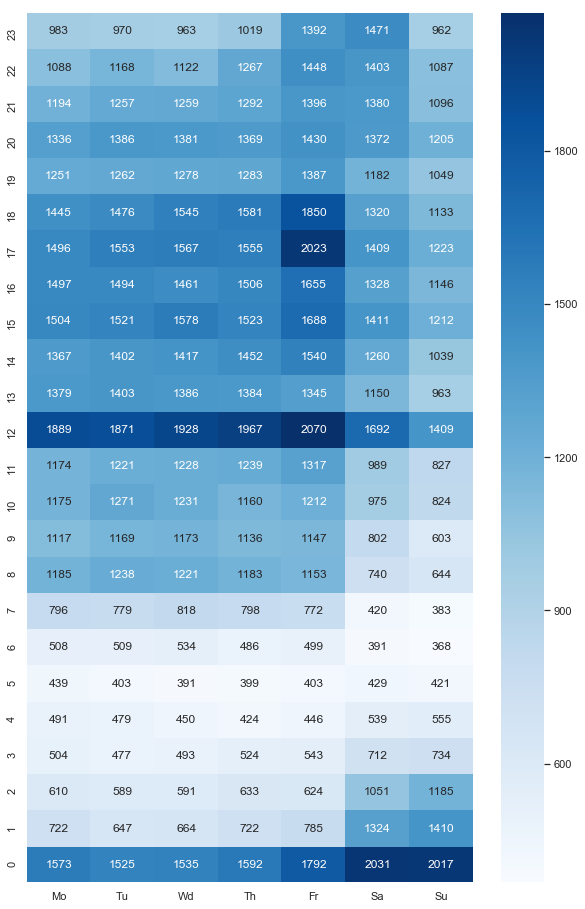

In [64]:
#cmap = sns.cm.rocket_r
plt.figure(figsize=(10,16))
cmap = "Blues"
sns.set()
ax = sns.heatmap(crimes_heatmap, cmap=cmap, annot=True, fmt='.0f', square=False, xticklabels=['Mo', 'Tu', 'Wd', 'Th', 'Fr', 'Sa', 'Su'])
ax.invert_yaxis()

In [65]:
#g= sns.jointplot(data=crimes_hour_day['Report Number'].unstack(), kind='hex')
#g.fix.axes[0].invert_yaxis()
#plt.show()

It appears that some incidents are simply reported as happening at 12 am or 12 pm without specifying exact time.

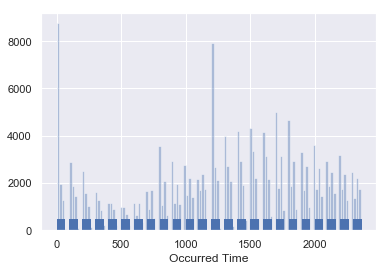

In [66]:
sns.distplot(crimes['Occurred Time'], kde=False, rug=True, bins=120);

In case the reported time is exactly 0, we replace it with a random time stamp between 0 and 1159, we do the same with 1200 by replacing it with a random value between 1200 and 2359

In [67]:
import random
def randomize_time(row):
    if row['Occurred Time'] == 0:
        return random.randint(0, 11) * 100;
    if row['Occurred Time'] == 1200:
        return random.randint(12,23) * 100;
    return row['Occurred Time']

crimes.apply(lambda row: randomize_time(row), axis=1).head() #check that the selection works
crimes['Randomized Time'] = crimes.apply(lambda row: randomize_time(row), axis=1)

E:\anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


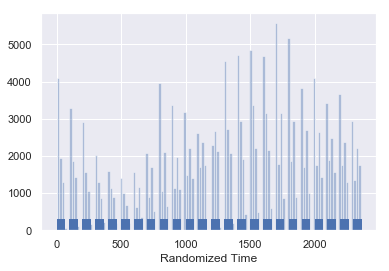

In [68]:
sns.distplot(crimes['Randomized Time'], kde=False, rug=True, bins=120);

In [69]:
crimes["Randomized Hour"] = crimes["Randomized Time"] / 100
crimes["Randomized Hour"] = crimes["Randomized Hour"].astype(int)
crimes_hour_day_rand = crimes.groupby(["Occurred Day of Week", "Randomized Hour"], axis=0).count()

E:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
E:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


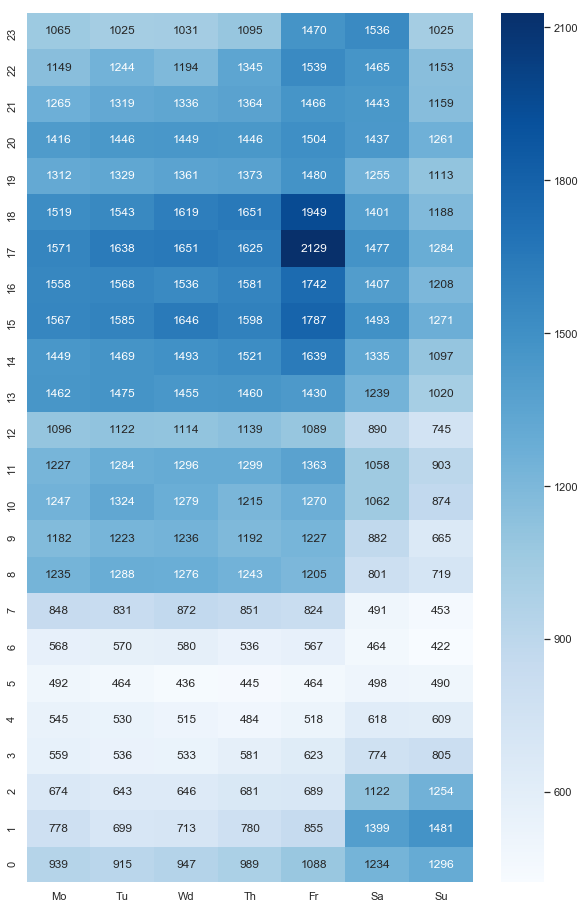

In [70]:
crimes_rand_heatmap = crimes_hour_day_rand['Report Number'].unstack().values[:, :].transpose() #np.newaxis]
plt.figure(figsize=(10,16))
cmap = "Blues"
sns.set()
ax = sns.heatmap(crimes_rand_heatmap, cmap=cmap, annot=True, fmt='.0f', square=False, xticklabels=['Mo', 'Tu', 'Wd', 'Th', 'Fr', 'Sa', 'Su'])
ax.invert_yaxis()

Next, we form a monthly breakdown by neighborhood

In [71]:
crimes_monthly = crimes.groupby(["Neighborhood", "YearMonth"]).count()
crimes_monthly.head()

Report Number  Occurred Date  Occurred Time  \
Neighborhood YearMonth                                                 
BALLARD      2009-01-01             64             64             64   
             2009-02-01             47             47             47   
             2009-03-01             81             81             81   
             2009-04-01             70             70             70   
             2009-05-01             47             47             47   

                         Reported Date  Reported Time  Crime Subcategory  \
Neighborhood YearMonth                                                     
BALLARD      2009-01-01             64             64                 64   
             2009-02-01             47             47                 47   
             2009-03-01             81             81                 80   
             2009-04-01             70             70                 69   
             2009-05-01             47             47                 47   

                         Primary Offense Description  Precinct  Sector  Beat  \
Neighborhood YearMonth                                                         
BALLARD      2009-01-01                           64        64      64    64   
             2009-02-01                           47        47      47    47   
             2009-03-01                           81        81      81    81   
             2009-04-01                           70        70      70    70   
             2009-05-01                           47        47      47    47   

                         Occurred Year  Occurred Month  Occurred Day of Week  \
Neighborhood YearMonth                                                         
BALLARD      2009-01-01             64              64                    64   
             2009-02-01             47              47                    47   
             2009-03-01             81              81                    81   
             2009-04-01             70              70                    70   
             2009-05-01             47              47                    47   

                         Occurred Hour  Randomized Time  Randomized Hour  
Neighborhood YearMonth                                                    
BALLARD      2009-01-01             64               64               64  
             2009-02-01             47               47               47  
             2009-03-01             81               81               81  
             2009-04-01             70               70               70  
             2009-05-01             47               47               47

Having our data grouped this way makes it easy to filter by a neighborhood like so:

In [72]:
crimes_monthly.loc["WEST SEATTLE"].tail()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Occurred Year,Occurred Month,Occurred Day of Week,Occurred Hour,Randomized Time,Randomized Hour
YearMonth,,,,,,,,,,,,,,,,
2018-08-01,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191
2018-09-01,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170
2018-10-01,194,194,194,194,194,194,194,194,194,194,194,194,194,194,194,194
2018-11-01,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149
2018-12-01,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178


Our multi-index contains just two levels:

In [73]:
crimes_monthly.index.names

FrozenList(['Neighborhood', 'YearMonth'])

In [74]:
crimes_monthly.index.levels[0]

Index(['BALLARD', 'BEACON HILL', 'BROADVIEW', 'CAPITOL HILL',
       'CENTRAL DISTRICT', 'CHINATOWN - INTL. DISTRICT',
       'COLUMBIA CITY/BRIGHTON', 'DOWNTOWN', 'EASTLAKE', 'FREMONT',
       'GEORGETOWN/SODO', 'GREEN LAKE/GREENWOOD', 'LAKE CITY', 'MADISON PARK',
       'MAGNOLIA/INTERBAY', 'MOUNT BAKER', 'NORTHEAST SEATTLE', 'NORTHGATE',
       'PHINNEY RIDGE', 'PIONEER SQUARE', 'QUEEN ANNE', 'RAINIER BEACH',
       'SOUTH LAKE UNION', 'UNIVERSITY DISTRICT', 'WALLINGFORD',
       'WEST SEATTLE'],
      dtype='object', name='Neighborhood')

Now lets plot the data for each neighborhood to have a better understanding of their structure

In [75]:
import matplotlib.pyplot as plt
import matplotlib.dates as matdates
import matplotlib.dates as mdates
from pandas.tseries import converter
#from pandas.plotting.register_matplotlib_converters import converter
converter.register()

E:\anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  


In [76]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

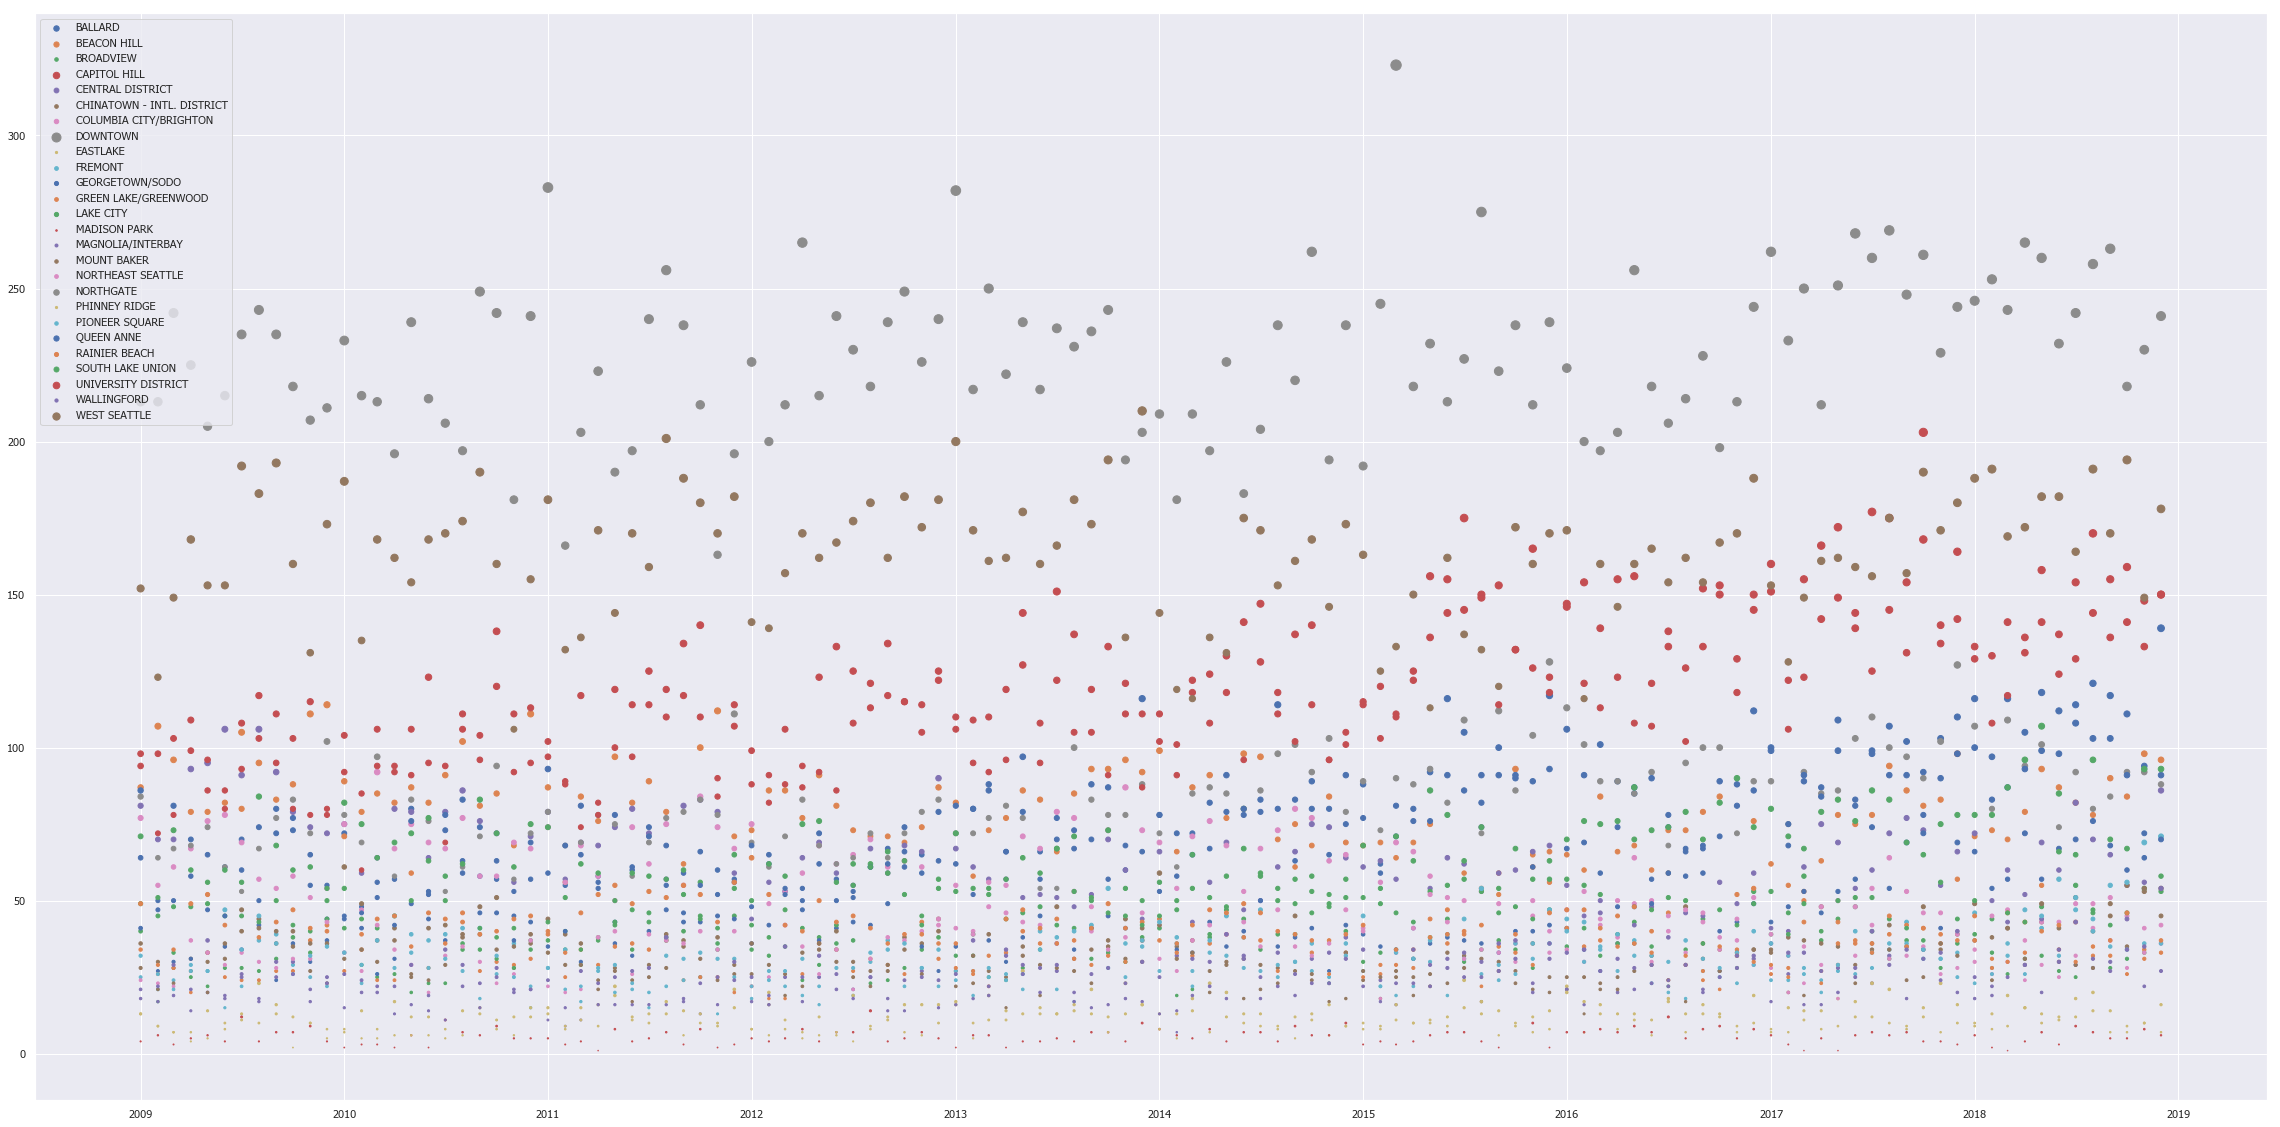

In [77]:
fig = plt.figure(figsize=(40,20))
#ax1 = fig.add_subplot(111)
for n in crimes_monthly.index.levels[0]:
    df_n = crimes_monthly.loc[n]
    #ax1.scatter(df_n.index.values.astype(dtype='datetime64[D]').tolist(), df_n["Report Number"].values, s=df_n["Report Number"]/3.0, label=n)
    plt.scatter(df_n.index.values.astype(dtype='datetime64[D]').tolist(), df_n["Report Number"].values, s=df_n["Report Number"]/3.0, label=n)
plt.legend(loc='best')
plt.savefig("CrimesMonthly.png")
plt.show()


Without weighing the data by the districts' population, it appears that most dangerous neighborhoods are Downtown, West Seattle, University District, and Capitol Hill. Lets divide the figures by the districts population.

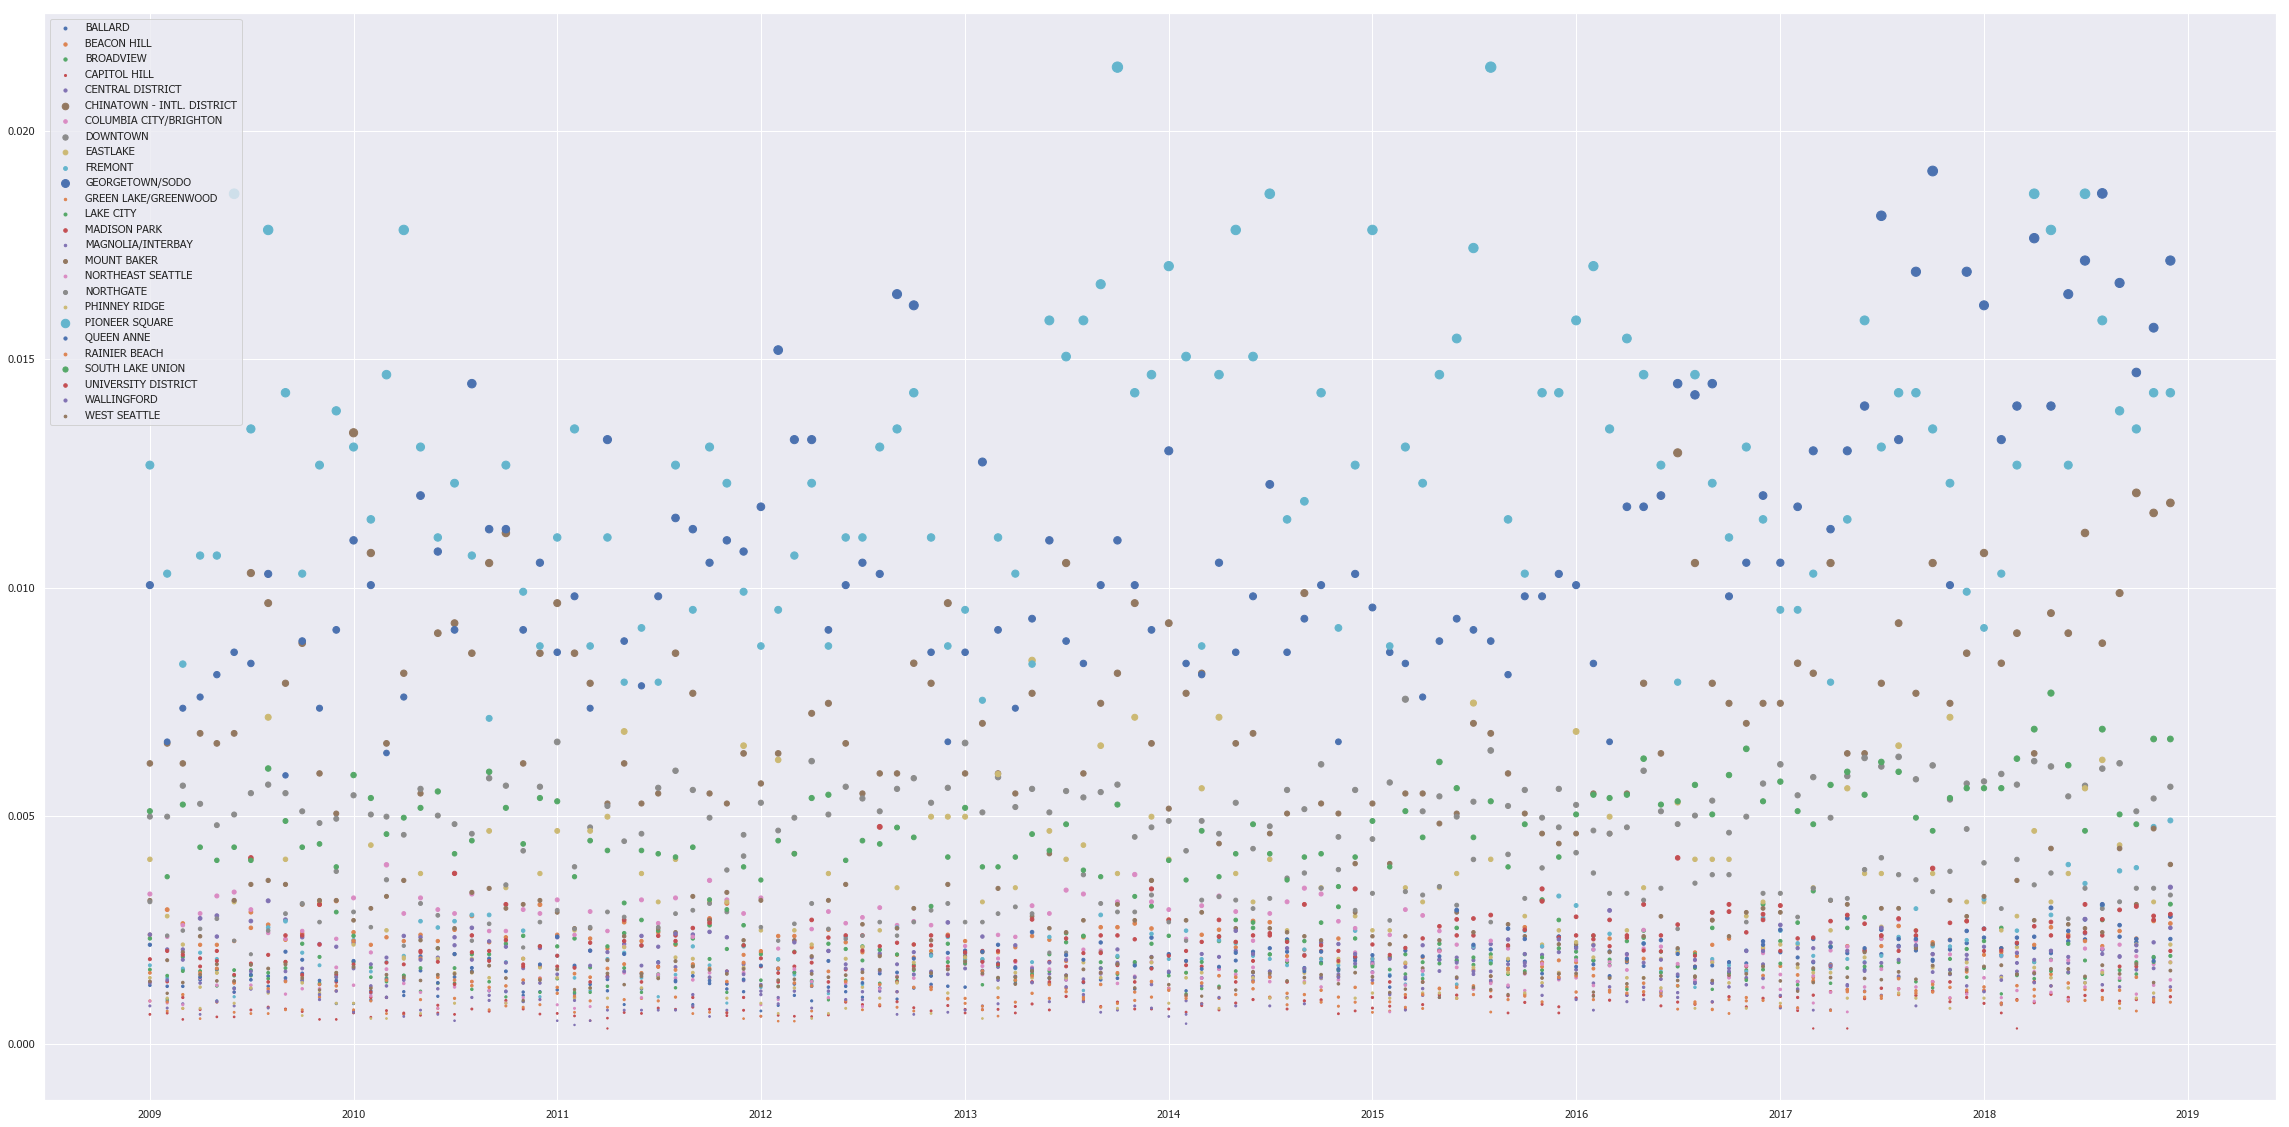

In [78]:
fig = plt.figure(figsize=(40,20))
#ax1 = fig.add_subplot(111)
for n in crimes_monthly.index.levels[0]:
    df_n = crimes_monthly.loc[n]
    #ax1.scatter(df_n.index.values.astype(dtype='datetime64[D]').tolist(), df_n["Report Number"].values, s=df_n["Report Number"]/3.0, label=n)
    number = df_n["Report Number"].apply(lambda x : x / population.loc[population["Neighborhood"]==n, "Est. Population"].iloc[0])
    plt.scatter(df_n.index.values.astype(dtype='datetime64[D]').tolist(), number.values, s=number * 5000.0, label=n)
plt.legend(loc='best')
plt.savefig("CrimesMonthlyNormalized.png")
plt.show()


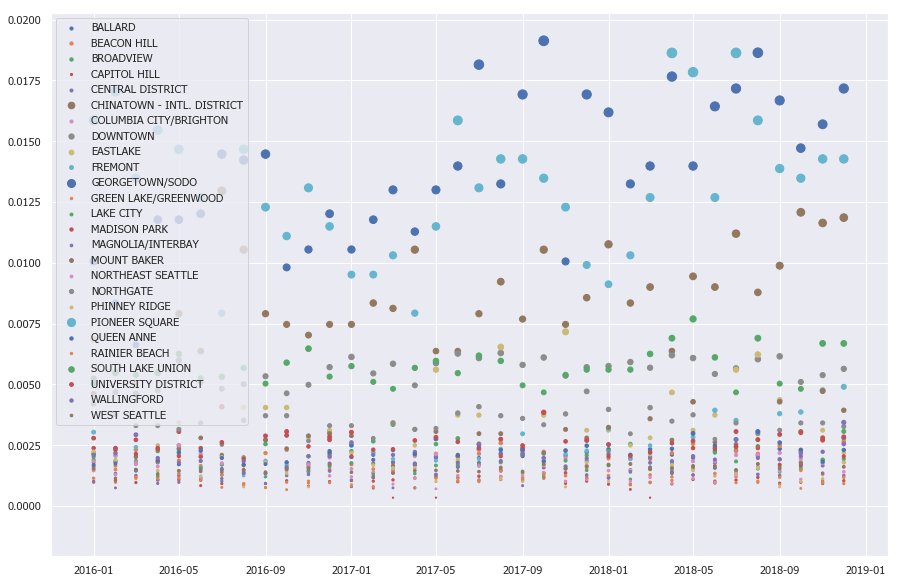

In [79]:
fig = plt.figure(figsize=(15,10))
#ax1 = fig.add_subplot(111)
for n in crimes_monthly.index.levels[0]:
    df_n = crimes_monthly.loc[n][-36:]
    #ax1.scatter(df_n.index.values.astype(dtype='datetime64[D]').tolist(), df_n["Report Number"].values, s=df_n["Report Number"]/3.0, label=n)
    number = df_n["Report Number"].apply(lambda x : x / population.loc[population["Neighborhood"]==n, "Est. Population"].iloc[0])
    plt.scatter(df_n.index.values.astype(dtype='datetime64[D]').tolist(), number.values, s=number * 5000.0, label=n)
plt.legend(loc='best')
plt.savefig("CrimesMonthlyNormalized3years.png")
plt.show()


Turns out that most dangerous districts over the whole time frame are Georgetown, Pioneer Square and Chinatown.

Now let's consider the tendency of crime rate by looking at crime rate rolling with the window of 24 months.

In [80]:
crimes_map = dict()
for n in crimes_monthly.index.levels[0]:
    df_n = crimes_monthly.loc[n]
    crimes_map[n] = df_n["Report Number"].apply(lambda x: x / population.loc[population["Neighborhood"] == n, "Est. Population"].iloc[0])

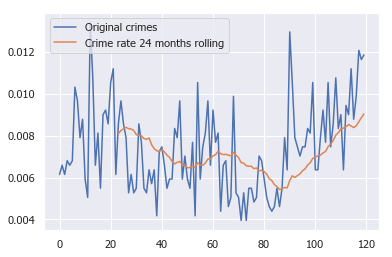

In [81]:
a = pd.DataFrame({'Original crimes' : crimes_map["CHINATOWN - INTL. DISTRICT"].values, 'Crime rate 24 months rolling': crimes_map["CHINATOWN - INTL. DISTRICT"].rolling(window=24).mean().values})
a.plot()
plt.show()

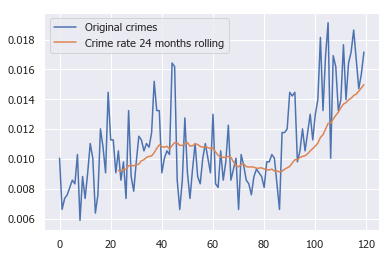

In [82]:
a = pd.DataFrame({'Original crimes' : crimes_map["GEORGETOWN/SODO"].values, 'Crime rate 24 months rolling': crimes_map["GEORGETOWN/SODO"].rolling(window=24).mean().values})
a.plot()
plt.show()

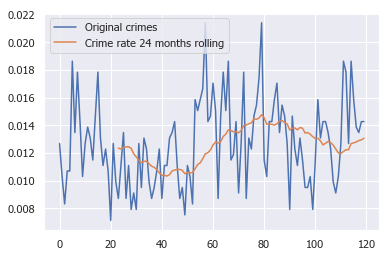

In [83]:
a = pd.DataFrame({'Original crimes' : crimes_map["PIONEER SQUARE"].values, 'Crime rate 24 months rolling': crimes_map["PIONEER SQUARE"].rolling(window=24).mean().values})
a.plot()
plt.show()

Having such a transformation of our data gives a better feel regarding the direction of crime rate, so let's apply this transformation and take only the very last data point as the reference of the crime rate of each district.

In [84]:
from collections import OrderedDict
crimes_rolling = OrderedDict()
for n in crimes_monthly.index.levels[0]:
    df_n = crimes_monthly.loc[n]
    full_df = df_n["Report Number"].apply(lambda x: x / population.loc[population["Neighborhood"] == n, "Est. Population"].iloc[0]).rolling(window=24).mean().values.tolist()
    crimes_rolling[n] = full_df[-1]
crimes_rolling

OrderedDict([('BALLARD', 0.0020582228471943214),
             ('BEACON HILL', 0.0021854429103177653),
             ('BROADVIEW', 0.0021530547367204205),
             ('CAPITOL HILL', 0.0010281889383431666),
             ('CENTRAL DISTRICT', 0.0018682115481369677),
             ('CHINATOWN - INTL. DISTRICT', 0.009037687522868638),
             ('COLUMBIA CITY/BRIGHTON', 0.0019007282865352337),
             ('DOWNTOWN', 0.005785900254119704),
             ('EASTLAKE', 0.003747795414462083),
             ('FREMONT', 0.0027385057471264376),
             ('GEORGETOWN/SODO', 0.014978747752166078),
             ('GREEN LAKE/GREENWOOD', 0.001066418683840402),
             ('LAKE CITY', 0.0015827872578695855),
             ('MADISON PARK', 0.001642315097972591),
             ('MAGNOLIA/INTERBAY', 0.0013107703236965652),
             ('MOUNT BAKER', 0.002924423855723569),
             ('NORTHEAST SEATTLE', 0.0011804417388589729),
             ('NORTHGATE', 0.0034755705560912888),
             ('

In [85]:
crimes_rolling.keys()

odict_keys(['BALLARD', 'BEACON HILL', 'BROADVIEW', 'CAPITOL HILL', 'CENTRAL DISTRICT', 'CHINATOWN - INTL. DISTRICT', 'COLUMBIA CITY/BRIGHTON', 'DOWNTOWN', 'EASTLAKE', 'FREMONT', 'GEORGETOWN/SODO', 'GREEN LAKE/GREENWOOD', 'LAKE CITY', 'MADISON PARK', 'MAGNOLIA/INTERBAY', 'MOUNT BAKER', 'NORTHEAST SEATTLE', 'NORTHGATE', 'PHINNEY RIDGE', 'PIONEER SQUARE', 'QUEEN ANNE', 'RAINIER BEACH', 'SOUTH LAKE UNION', 'UNIVERSITY DISTRICT', 'WALLINGFORD', 'WEST SEATTLE'])

In [86]:
crimes_rolling.values()

odict_values([0.0020582228471943214, 0.0021854429103177653, 0.0021530547367204205, 0.0010281889383431666, 0.0018682115481369677, 0.009037687522868638, 0.0019007282865352337, 0.005785900254119704, 0.003747795414462083, 0.0027385057471264376, 0.014978747752166078, 0.001066418683840402, 0.0015827872578695855, 0.001642315097972591, 0.0013107703236965652, 0.002924423855723569, 0.0011804417388589729, 0.0034755705560912888, 0.0014181824945132613, 0.013063152331880039, 0.002366299347924985, 0.001115953092860021, 0.0057693228904696905, 0.0026579274958452594, 0.0019375530110262937, 0.0015319346856203602])

In [87]:
crimes_2 = pd.DataFrame({'District': list(crimes_rolling.keys()), 'Crime rate': list(crimes_rolling.values())})
crimes_2.head()

,District,Crime rate
0,BALLARD,0.002058
1,BEACON HILL,0.002185
2,BROADVIEW,0.002153
3,CAPITOL HILL,0.001028
4,CENTRAL DISTRICT,0.001868


In [88]:
from collections import OrderedDict

def plot_bar_chart(label_to_value, title, x_label, y_label):
    """
    Plots a bar chart from a dict.

    Args:
        label_to_value: A dict mapping ints or strings to numerical values (int
            or float).
        title: A string representing the title of the graph.
        x_label: A string representing the label for the x-axis.
        y_label: A string representing the label for the y-axis.
    """
    n = len(label_to_value)
    #labels = sorted(label_to_value.items(), key=lambda x: x[1])
    sorted_by_value = OrderedDict(sorted(label_to_value.items(), key=lambda x: -x[1]))
    #values = [label_to_value[label] for label in labels]
    fig = plt.figure(figsize=(20,12))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.bar(range(n), sorted_by_value.values(), align='center')
    plt.xticks(range(n), sorted_by_value.keys(), rotation=90, fontsize='8')
    plt.gcf().subplots_adjust(bottom=0.2) # make room for x-axis labels
    fig.tight_layout()
    return fig
#plt.show() 

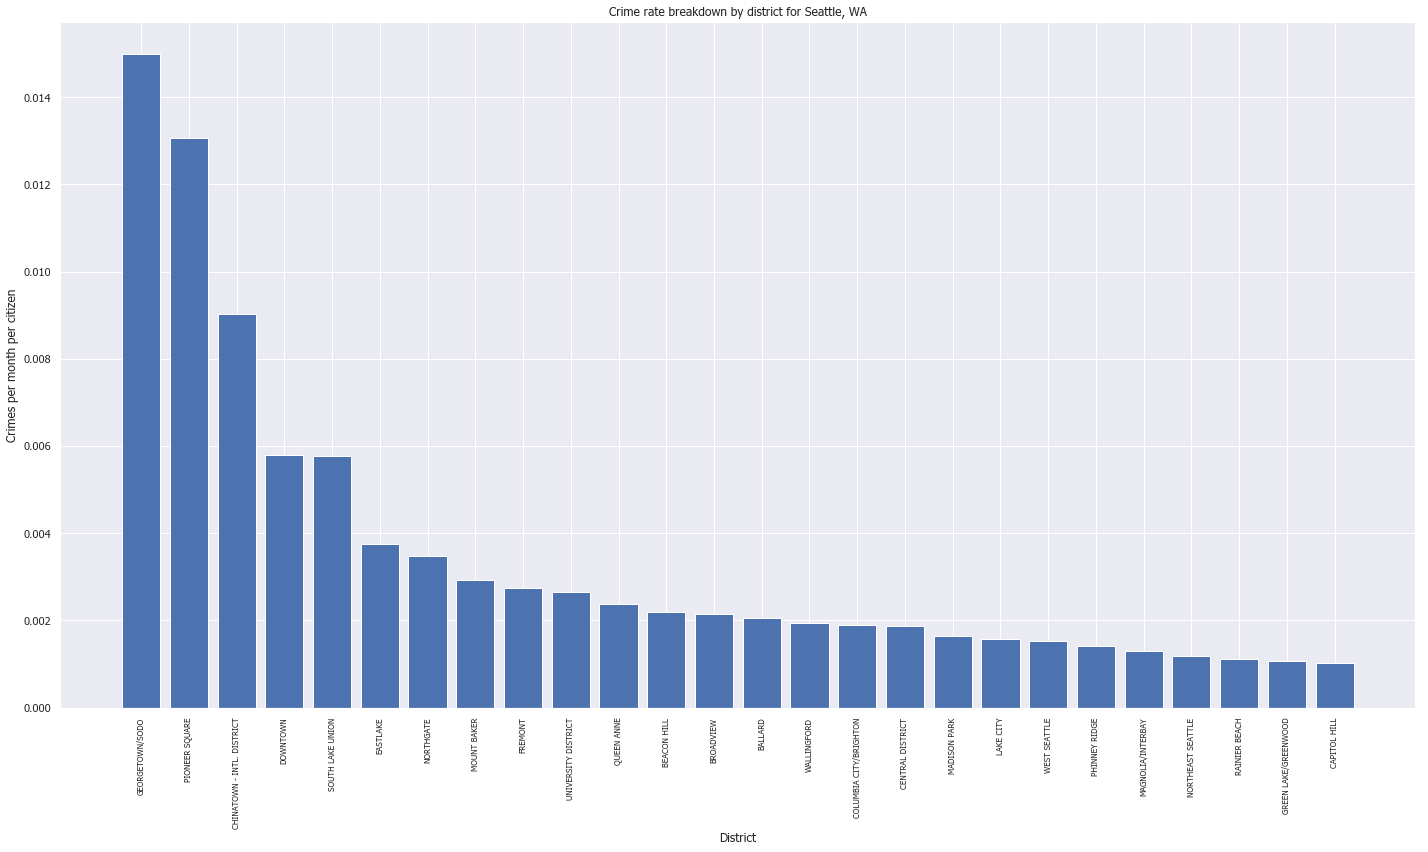

In [89]:

#font = {'weight' : 'bold', 'size' : 52, 'family' : 'sans-serif'}
#matplotlib.rc('font', **font)
fig = plot_bar_chart(crimes_rolling, "Crime rate breakdown by district for Seattle, WA", "District", "Crimes per month per citizen")
plt.savefig("CrimeRateDistricts.png")
plt.show()

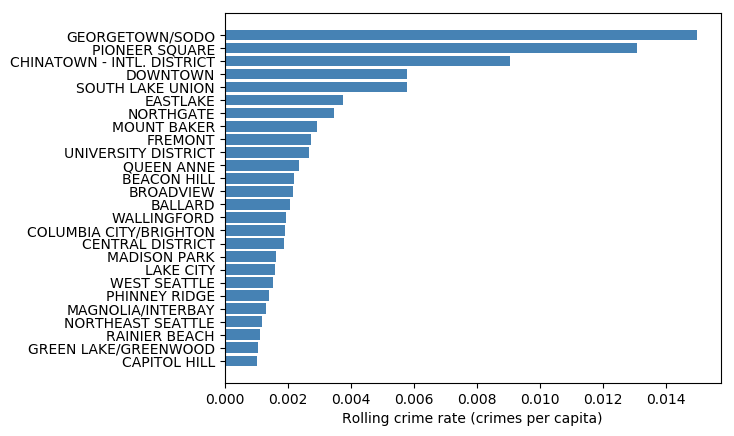

In [90]:
sorted_by_value = OrderedDict(sorted(crimes_rolling.items(), key=lambda x: -x[1]))

districts_ = sorted_by_value.keys()
y_pos_ = np.arange(len(districts_))
crimes_ = list(sorted_by_value.values())
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y_pos_, crimes_, align='center',
        color='#4682B4', ecolor='black')
ax.set_yticks(y_pos_)
ax.set_yticklabels(districts_)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Rolling crime rate (crimes per capita)')
#ax.set_title('')
plt.savefig("CrimeRateDistricts.png")

Lets take a look at the of crime rate dataset: draw a histogram and fit a kernel densitay estimate.

In [91]:
x = pd.Series(list(crimes_rolling.values()), name="Rolling crime rate for districts")

E:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


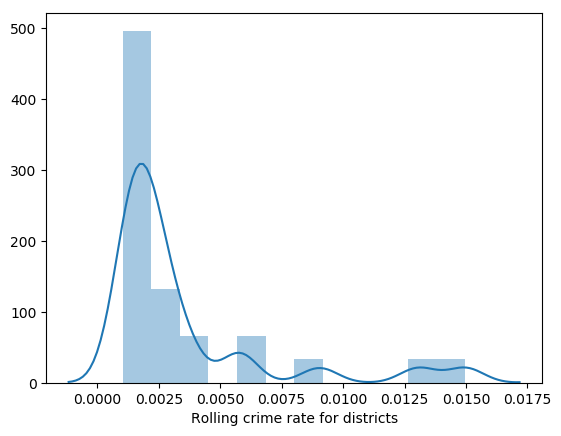

In [92]:
sns.distplot(x);

Histogram of distribution of crime rate data (each vertical tick represents an observation, and histogram is bars indicate how many of them fell into that bin).

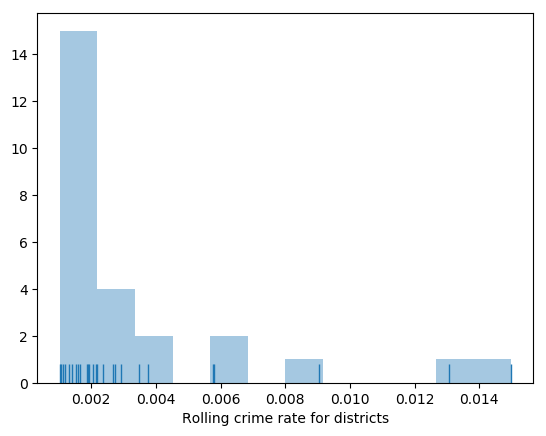

In [93]:
sns.distplot(x, kde=False, rug=True);

It is apparent, that our data follow Poisson distribution. (see the below histogram with increased number of bins)

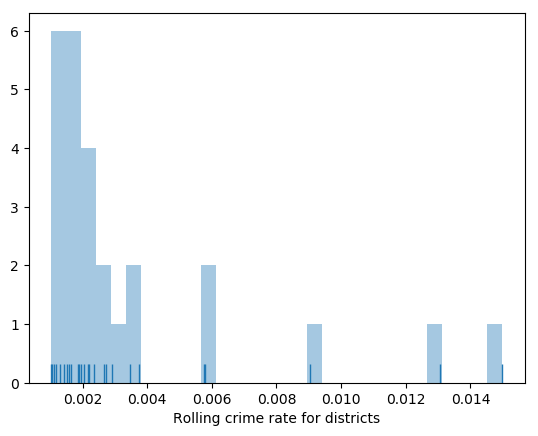

In [94]:
sns.distplot(x, kde=False, rug=True, bins=30);

For our analysis, we are rather interested in quantiles of a distribution.

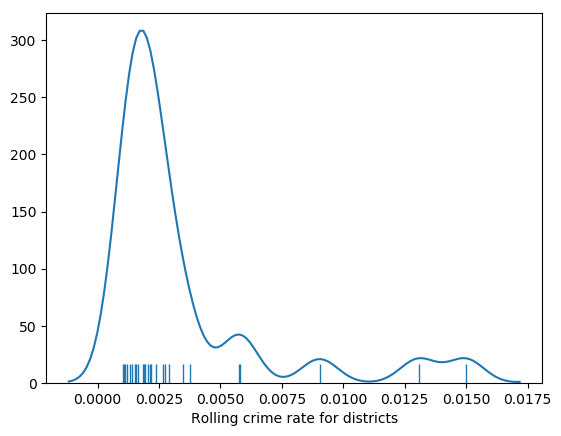

In [95]:
sns.distplot(x, hist=False, rug=True);

In [96]:
# @hidden cell

#See more details in Seaboarn tutorial under the following link: https://seaborn.pydata.org/tutorial/distributions.html

#### Data acquisition part 4: Median rental price
The data from findmyseattle.com contain median rental price per district too. 
Let us invetiage the data to see if can be of any use.

In [97]:
rental = population['Median Rental Price']

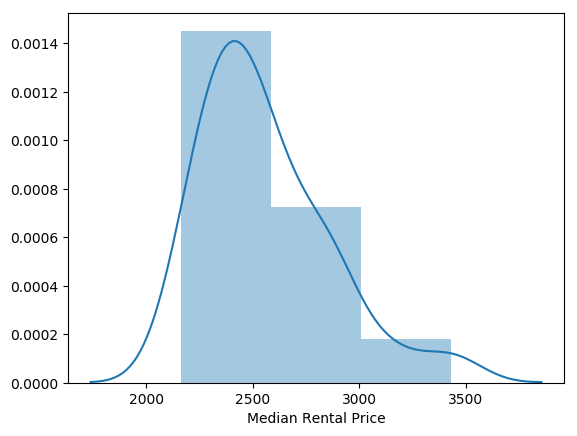

In [98]:
sns.distplot(rental)

### Data acquisition part 4: Foursquare data for parks nearby 

In [99]:
ballard_lat = 47.677
ballard_long = -122.385
ballard_name = "BALLARD"

Connect to foursquare and try to fetch parks in vicinity of Ballard's center (1.5 km)

In [100]:
# @hidden_cell
CLIENT_ID = '15ISGMBQ1IVQOGYCPONT332M5OPCLPQD23F05U3NCSXQ4VF4' # your Foursquare ID
CLIENT_SECRET = 'RMLTCPWCXGDJ0GM12DTVQY3LCZKWQDTABJW1Z3DYYLAWXD5C' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [101]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1500 # define radius
categoryId = '4bf58dd8d48988d163941735' # category for parks according to https://developer.foursquare.com/docs/resources/categories
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    ballard_lat, 
    ballard_long, 
    radius, 
    LIMIT,
    categoryId)

In [102]:
import requests
results = requests.get(url).json()

In [103]:
parks = results['response']['groups'][0]['items']

In [104]:
from pandas.io.json import json_normalize 
nearby_parks = json_normalize(parks)
nearby_parks.columns = [col.split(".")[-1] for col in nearby_parks.columns]

In [105]:
nearby_parks

,count,items,referralId,categories,id,address,cc,city,country,crossStreet,...,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,name,count,groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bcba84acc8cd13a86e6bfcf-0,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",4bcba84acc8cd13a86e6bfcf,2644 NW 60th St.,US,Seattle,United States,NaN,...,"[2644 NW 60th St., Seattle, WA 98107, United S...","[{'label': 'display', 'lat': 47.67299012328336...",47.672990,-122.391043,NaN,98107,WA,Ballard Playfield,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b98214cf964a520822e35e3-1,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",4b98214cf964a520822e35e3,1418 NW 65th St,US,Seattle,United States,NaN,...,"[1418 NW 65th St, Seattle, WA 98117, United St...","[{'label': 'display', 'lat': 47.67701977664608...",47.677020,-122.374965,NaN,98117,WA,Ballard High School,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4e1b8e89887735dda33b2798-2,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",4e1b8e89887735dda33b2798,NaN,US,Ballard,United States,NaN,...,"[Ballard, WA, United States]","[{'label': 'display', 'lat': 47.66657014689458...",47.666570,-122.396728,Ballard,NaN,WA,Ballard Locks Visitor Center,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-49bd9eabf964a5208b541fe3-3,"[{'id': '4bf58dd8d48988d1f2941735', 'name': 'S...",49bd9eabf964a5208b541fe3,5209 Ballard Ave NW,US,Seattle,United States,20th ave nw,...,"[5209 Ballard Ave NW (20th ave nw), Seattle, W...","[{'label': 'display', 'lat': 47.66577199566534...",47.665772,-122.382465,NaN,98107,WA,Second Ascent,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4abe8bf3f964a520678e20e3-4,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",4abe8bf3f964a520678e20e3,6201 17th Ave. NW,US,Seattle,United States,NaN,...,"[6201 17th Ave. NW, Seattle, WA 98107, United ...","[{'label': 'display', 'lat': 47.67444035425347...",47.674440,-122.379042,Ballard,98107,WA,Ballard Corners Park,0,[]
5,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5c60af6b82a750002c48d1a6-5,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",5c60af6b82a750002c48d1a6,NaN,US,Seattle,United States,NaN,...,"[Seattle, WA 98107, United States]","[{'label': 'display', 'lat': 47.672286, 'lng':...",47.672286,-122.373593,NaN,98107,WA,Gemenskap Park,0,[]
6,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-58a62c97e18e656cc646d02c-6,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",58a62c97e18e656cc646d02c,NaN,US,Seattle,United States,NaN,...,"[Seattle, WA, United States]","[{'label': 'display', 'lat': 47.668336, 'lng':...",47.668336,-122.378856,NaN,NaN,WA,Mighty-O Parklet,0,[]
7,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-575467ba498e0f8339028686-7,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",575467ba498e0f8339028686,5300 28th Ave NW,US,Seattle,United States,Waterfront,...,"[5300 28th Ave NW (Waterfront), Seattle, WA 98...","[{'label': 'display', 'lat': 47.667347, 'lng':...",47.667347,-122.392746,NaN,98107,WA,28th Ave NW Street End Park,0,[]
8,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bae53c5f964a52028a33be3-8,"[{'id': '4bf58dd8d48988d1e7941735', 'name': 'P...",4bae53c5f964a52028a33be3,3025 NW 68th St.,US,Seattle,United States,NaN,...,"[3025 NW 68th St., Seattle, WA 98117, United S...","[{'label': 'display', 'lat': 47.67767251848031...",47.677673,-122.397694,NaN,98117,WA,Webster Park,0,[]
9,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bcbcee7937ca593b453aa92-9,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",4bcbcee7937ca593b453aa92,22nd Ave. NW & Ballard Ave. NW,US,Seattle,United States,NaN,...,"[22nd Ave. NW & Ballard Ave. NW, Seattle, WA 9...","[{'label': 'display', 'lat': 47.66784078732754...",47.667841,-122.384980,NaN,98107,WA,Marvin's Garden,0,[]


Great! Our test query has worked, finding us 14 parks.

In [106]:
# add markers to map
map_seattle = folium.Map(location=[ballard_lat, ballard_long], zoom_start=15)

for lat, lng, name in zip(nearby_parks['lat'], nearby_parks['lng'], nearby_parks['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle) 

In [107]:
map_seattle

All parks are located in the Ballard district.

Now lets obtain locations of all parks in the whole Seattle: we enter it's coordinates and seach for parks in radius of 30 km

In [108]:
LIMIT = 1000000 # limit of number of venues returned by Foursquare API
radius = 30000 # define radius
categoryId = '4bf58dd8d48988d163941735' # category for parks according to https://developer.foursquare.com/docs/resources/categories
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    seattle_latitude, 
    seattle_longitude, 
    radius, 
    LIMIT,
    categoryId)

In [109]:
results = requests.get(url).json()
parks = results['response']['groups'][0]['items']
seattle_parks = json_normalize(parks)

In [110]:
seattle_parks.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [111]:
seattle_parks = seattle_parks[['venue.name','venue.id','venue.location.lat','venue.location.lng']]
seattle_parks.set_index(seattle_parks['venue.id'], inplace=True)

In [112]:
seattle_parks.head()

,venue.name,venue.id,venue.location.lat,venue.location.lng
venue.id,,,,
4be9c56d61aca59369f68200,South Lake Union,4be9c56d61aca59369f68200,47.626690,-122.337510
4a7f26dff964a5200df31fe3,Dr. Jose Rizal Park,4a7f26dff964a5200df31fe3,47.592779,-122.318333
430bb880f964a52039271fe3,Discovery Park,430bb880f964a52039271fe3,47.658173,-122.410261
490d85a7f964a52063521fe3,Luther Burbank Park,490d85a7f964a52063521fe3,47.590961,-122.226060
488db78ff964a52055511fe3,Bellevue Downtown Park,488db78ff964a52055511fe3,47.612860,-122.203805


In [113]:
seattle_parks.shape

(100, 4)

Turns out, Foursquare won't returns us more that 100 venues at once.
Lets then use the coordinates of each district we've obtain from wikipedia, ask FourSquare for parks inside and then merge the results.

In [114]:
'''# we comment out this code for now, otherwise we'll exhaust our quata on FourSquare. 
    # also we persist all the results we need into a local file
    
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius
categoryId = '4bf58dd8d48988d163941735' # category for parks according to https://developer.foursquare.com/docs/resources/categories
for index, row in districts_coords.iterrows():
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        row['Latitude'], 
        row['Longitude'], 
        radius, 
        LIMIT,
        categoryId)
    results = requests.get(url).json()
    parks = results['response']['groups'][0]['items']
    normalized_parks = json_normalize(parks)
    normalized_parks = normalized_parks[['venue.name','venue.id','venue.location.lat','venue.location.lng']]
    normalized_parks.set_index(normalized_parks['venue.id'], inplace=True)
    seattle_parks = pd.concat([seattle_parks, normalized_parks])
'''


"# we comment out this code for now, otherwise we'll exhaust our quata on FourSquare. \n    # also we persist all the results we need into a local file\n    \nLIMIT = 100 # limit of number of venues returned by Foursquare API\nradius = 5000 # define radius\ncategoryId = '4bf58dd8d48988d163941735' # category for parks according to https://developer.foursquare.com/docs/resources/categories\nfor index, row in districts_coords.iterrows():\n    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(\n        CLIENT_ID, \n        CLIENT_SECRET, \n        VERSION, \n        row['Latitude'], \n        row['Longitude'], \n        radius, \n        LIMIT,\n        categoryId)\n    results = requests.get(url).json()\n    parks = results['response']['groups'][0]['items']\n    normalized_parks = json_normalize(parks)\n    normalized_parks = normalized_parks[['venue.name','venue.id','venue.location.lat','venue.locatio

In [115]:
seattle_parks.head()

,venue.name,venue.id,venue.location.lat,venue.location.lng
venue.id,,,,
4be9c56d61aca59369f68200,South Lake Union,4be9c56d61aca59369f68200,47.626690,-122.337510
4a7f26dff964a5200df31fe3,Dr. Jose Rizal Park,4a7f26dff964a5200df31fe3,47.592779,-122.318333
430bb880f964a52039271fe3,Discovery Park,430bb880f964a52039271fe3,47.658173,-122.410261
490d85a7f964a52063521fe3,Luther Burbank Park,490d85a7f964a52063521fe3,47.590961,-122.226060
488db78ff964a52055511fe3,Bellevue Downtown Park,488db78ff964a52055511fe3,47.612860,-122.203805


In [116]:
#seattle_parks.drop_duplicates(inplace=True)

In [117]:
seattle_parks.shape

(100, 4)

We've located 707 different parks in vicinity of Seattle, WA.

In [118]:
#seattle_parks.to_csv("SeattleParks.csv")
seattle_parks = pd.read_csv("SeattleParks.csv")
seattle_parks.shape

(707, 5)

In [119]:
map_seattle_parks = folium.Map(location=[seattle_latitude, seattle_longitude], zoom_start=11)

for lat, lng, name in zip(seattle_parks['venue.location.lat'], seattle_parks['venue.location.lng'], seattle_parks['venue.name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle_parks)
map_seattle_parks

### Data acquisition part 5: Obtain AirBnB activity data for Seattle 
    We use the following data set provided by AirBnB: https://www.kaggle.com/airbnb/seattle/version/2#_=_
    We download the CSV files into IBM cloud and process them.
    File 'listings' contains the available listings with their price. Some of them have no price provided, we'd need to filter them out.


In [120]:
#import types

#from botocore.client import Config
#import ibm_boto3

#def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
#client_a0ef65717c914cf4b77b78d5d1052f79 = ibm_boto3.client(service_name='s3',
#    ibm_api_key_id='-8mOlYnCyIi-zvK1ehx_Uk2Razz26Bc66BF5k2KPO7kE',
#    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
#    config=Config(signature_version='oauth'),
#    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

#body = client_a0ef65717c914cf4b77b78d5d1052f79.get_object(Bucket='courseracapstoneyurychebiryak-donotdelete-pr-szy93cgkynqru9',Key='SeattleAirbnbListings.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

#flats = pd.read_csv(body)
flats = pd.read_csv("SeattleAirbnbListings.csv")

In [121]:
flats.shape

(3818, 92)

In [122]:
flats.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [123]:
flats["neighbourhood"] = flats["neighbourhood"].astype(str)

In [124]:
flats[["name", "latitude", "longitude", "price", "review_scores_rating", "neighbourhood", "weekly_price"]].head()

,name,latitude,longitude,price,review_scores_rating,neighbourhood,weekly_price
0,Stylish Queen Anne Apartment,47.636289,-122.371025,$85.00,95.0,Queen Anne,NaN
1,Bright & Airy Queen Anne Apartment,47.639123,-122.365666,$150.00,96.0,Queen Anne,"$1,000.00"
2,New Modern House-Amazing water view,47.629724,-122.369483,$975.00,97.0,Queen Anne,NaN
3,Queen Anne Chateau,47.638473,-122.369279,$100.00,NaN,Queen Anne,$650.00
4,Charming craftsman 3 bdm house,47.632918,-122.372471,$450.00,92.0,Queen Anne,NaN


We do the data cleaning using Wikipedia and findmyseattle.com again

In [125]:
flats.loc[flats['neighbourhood'] == 'Alki', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Anaheim', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Arbor Heights', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Atlantic', 'neighbourhood'] = 'CENTRAL DISTRICT'
flats.loc[flats['neighbourhood'] == 'Baldwin Hills', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Ballard', 'neighbourhood'] = 'BALLARD'
flats.loc[flats['neighbourhood'] == 'Belltown', 'neighbourhood'] = 'DOWNTOWN'
flats.loc[flats['neighbourhood'] == 'Beverly Hills', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Bitter Lake', 'neighbourhood'] = 'BROADVIEW'
flats.loc[flats['neighbourhood'] == 'Brighton', 'neighbourhood'] = 'COLUMBIA CITY/BRIGHTON'
flats.loc[flats['neighbourhood'] == 'Broadview', 'neighbourhood'] = 'BROADVIEW'
flats.loc[flats['neighbourhood'] == 'Broadway', 'neighbourhood'] = 'CAPITOL HILL'
flats.loc[flats['neighbourhood'] == 'Bryant', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Capitol Hill', 'neighbourhood'] = 'CAPITOL HILL'
flats.loc[flats['neighbourhood'] == 'Cedar Park', 'neighbourhood'] = 'LAKE CITY'
flats.loc[flats['neighbourhood'] == 'Central Business District', 'neighbourhood'] = 'DOWNTOWN'
flats.loc[flats['neighbourhood'] == 'Central San Pedro', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Clairemont Mesa East', 'neighbourhood'] = 'MOUNT BAKER'
flats.loc[flats['neighbourhood'] == 'Columbia City', 'neighbourhood'] = 'COLUMBIA CITY/BRIGHTON'
flats.loc[flats['neighbourhood'] == 'Crown Hill', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Downtown Toronto', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Dunlap', 'neighbourhood'] = 'COLUMBIA CITY/BRIGHTON'
flats.loc[flats['neighbourhood'] == 'East Village', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Eastlake', 'neighbourhood'] = 'EASTLAKE'
flats.loc[flats['neighbourhood'] == 'Fairmount Park', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Fauntleroy', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Fenway/Kenmore', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'First Hill', 'neighbourhood'] = 'DOWNTOWN'
flats.loc[flats['neighbourhood'] == 'Forestland', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Fremont', 'neighbourhood'] = 'FREMONT'
flats.loc[flats['neighbourhood'] == 'Gatewood', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Genesee', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Georgetown', 'neighbourhood'] = 'GEORGETOWN/SODO'
flats.loc[flats['neighbourhood'] == 'Green Lake', 'neighbourhood'] = 'GREEN LAKE/GREENWOOD'
flats.loc[flats['neighbourhood'] == 'Greenwood', 'neighbourhood'] = 'GREEN LAKE/GREENWOOD'
flats.loc[flats['neighbourhood'] == 'Haller Lake', 'neighbourhood'] = 'NORTHGATE'
flats.loc[flats['neighbourhood'] == 'Harrison/Denny-Blaine', 'neighbourhood'] = 'CENTRAL DISTRICT'
flats.loc[flats['neighbourhood'] == 'Hell\'s Kitchen', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'High Point', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Highland Park', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Holly', 'neighbourhood'] = 'BEACON HILL'
flats.loc[flats['neighbourhood'] == 'Holly Park', 'neighbourhood'] = 'BEACON HILL'
flats.loc[flats['neighbourhood'] == 'Hollywood', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Huntington Beach', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Industrial District', 'neighbourhood'] = 'GEORGETOWN/SODO'
flats.loc[flats['neighbourhood'] == 'Interbay', 'neighbourhood'] = 'MAGNOLIA/INTERBAY'
flats.loc[flats['neighbourhood'] == 'International District', 'neighbourhood'] = 'CHINATOWN - INTL. DISTRICT'
flats.loc[flats['neighbourhood'] == 'Jamaica Plain', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Kaanapali', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Kauaʻi', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Laurelhurst', 'neighbourhood'] = 'NORTHEAST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Leschi', 'neighbourhood'] = 'CENTRAL DISTRICT'
flats.loc[flats['neighbourhood'] == 'Licton Springs', 'neighbourhood'] = 'NORTHGATE'
flats.loc[flats['neighbourhood'] == 'Long Beach', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Lower Queen Anne', 'neighbourhood'] = 'QUEEN ANNE'
flats.loc[flats['neighbourhood'] == 'Madison Park', 'neighbourhood'] = 'MADISON PARK'
flats.loc[flats['neighbourhood'] == 'Madrona', 'neighbourhood'] = 'CENTRAL DISTRICT'
flats.loc[flats['neighbourhood'] == 'Magnolia', 'neighbourhood'] = 'MAGNOLIA/INTERBAY'
flats.loc[flats['neighbourhood'] == 'Manhattan Beach', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Maple Leaf', 'neighbourhood'] = 'NORTHGATE'
flats.loc[flats['neighbourhood'] == 'Mathews Beach', 'neighbourhood'] = 'LAKE CITY'
flats.loc[flats['neighbourhood'] == 'Meadowbrook', 'neighbourhood'] = 'LAKE CITY'
flats.loc[flats['neighbourhood'] == 'Minor', 'neighbourhood'] = 'CENTRAL DISTRICT'
flats.loc[flats['neighbourhood'] == 'Mission District', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Montlake', 'neighbourhood'] = 'CAPITOL HILL'
flats.loc[flats['neighbourhood'] == 'Mount Baker', 'neighbourhood'] = 'MOUNT BAKER'
flats.loc[flats['neighbourhood'] == 'North Admiral', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'North Beach/Blue Ridge', 'neighbourhood'] = 'BALLARD'
flats.loc[flats['neighbourhood'] == 'North Beacon Hill', 'neighbourhood'] = 'BEACON HILL'
flats.loc[flats['neighbourhood'] == 'North College Park', 'neighbourhood'] = 'NORTHGATE'
flats.loc[flats['neighbourhood'] == 'North Delridge', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'North Hollywood', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Northwest District', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Olympic Hills', 'neighbourhood'] = 'LAKE CITY'
flats.loc[flats['neighbourhood'] == 'Phinney Ridge', 'neighbourhood'] = 'PHINNEY RIDGE'
flats.loc[flats['neighbourhood'] == 'Pike Market', 'neighbourhood'] = 'CAPITOL HILL'
flats.loc[flats['neighbourhood'] == 'Pike Place Market', 'neighbourhood'] = 'CAPITOL HILL'
flats.loc[flats['neighbourhood'] == 'Pinehurst', 'neighbourhood'] = 'NORTHGATE'
flats.loc[flats['neighbourhood'] == 'Pioneer Square', 'neighbourhood'] = 'PIONEER SQUARE'
flats.loc[flats['neighbourhood'] == 'Portage Bay', 'neighbourhood'] = 'CAPITOL HILL'
flats.loc[flats['neighbourhood'] == 'Queen Anne', 'neighbourhood'] = 'QUEEN ANNE'
flats.loc[flats['neighbourhood'] == 'Rainier Beach', 'neighbourhood'] = 'RAINIER BEACH'
flats.loc[flats['neighbourhood'] == 'Ravenna', 'neighbourhood'] = 'UNIVERSITY DISTRICT'
flats.loc[flats['neighbourhood'] == 'Riverview', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Roosevelt', 'neighbourhood'] = 'UNIVERSITY DISTRICT'
flats.loc[flats['neighbourhood'] == 'Roxhill', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Santa Monica', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Seaview', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Seward Park', 'neighbourhood'] = 'COLUMBIA CITY/BRIGHTON'
flats.loc[flats['neighbourhood'] == 'South Beacon Hill', 'neighbourhood'] = 'BEACON HILL'
flats.loc[flats['neighbourhood'] == 'South Delridge', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'South Lake Union', 'neighbourhood'] = 'SOUTH LAKE UNION'
flats.loc[flats['neighbourhood'] == 'South Park', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Stevens', 'neighbourhood'] = 'CAPITOL HILL'
flats.loc[flats['neighbourhood'] == 'The Junction', 'neighbourhood'] = 'WEST SEATTLE'
flats.loc[flats['neighbourhood'] == 'University District', 'neighbourhood'] = 'UNIVERSITY DISTRICT'
flats.loc[flats['neighbourhood'] == 'Victory Heights', 'neighbourhood'] = 'LAKE CITY'
flats.loc[flats['neighbourhood'] == 'View Ridge', 'neighbourhood'] = 'NORTHEAST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Waianae Coast', 'neighbourhood'] = 'N/A'
flats.loc[flats['neighbourhood'] == 'Wallingford', 'neighbourhood'] = 'WALLINGFORD'
flats.loc[flats['neighbourhood'] == 'Wedgewood', 'neighbourhood'] = 'NORTHEAST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Westlake', 'neighbourhood'] = 'SOUTH LAKE UNION'
flats.loc[flats['neighbourhood'] == 'Windermere', 'neighbourhood'] = 'NORTHEAST SEATTLE'
flats.loc[flats['neighbourhood'] == 'Yesler Terrace', 'neighbourhood'] = 'DOWNTOWN'
flats.loc[flats['neighbourhood'] == 'nan', 'neighbourhood'] = 'N/A'
flats.drop(flats[flats["neighbourhood"] == "N/A"].index, inplace=True)

In [126]:
print(set(crimes["Neighborhood"].unique()).symmetric_difference(set(flats["neighbourhood"].unique())))

set()


Names are the same now 

Let's measure mean rental prices in each district

In [127]:
flats['price'] = flats['price'].str.replace("$","");
flats['price'] = flats['price'].str.replace(",","");
flats.price = flats.price.astype(float)
flats_by_district = flats.groupby(["neighbourhood"]).mean();

In [128]:
flats_dict = OrderedDict()
for n in flats_by_district.index: #.levels[0]:
    df_n = flats_by_district.loc[n]
    flats_dict[n] = df_n["price"]
flats_dict

OrderedDict([('BALLARD', 124.09375),
             ('BEACON HILL', 92.3495145631068),
             ('BROADVIEW', 92.10344827586206),
             ('CAPITOL HILL', 135.0435606060606),
             ('CENTRAL DISTRICT', 129.92330383480825),
             ('CHINATOWN - INTL. DISTRICT', 105.76470588235294),
             ('COLUMBIA CITY/BRIGHTON', 97.66666666666667),
             ('DOWNTOWN', 157.30348258706468),
             ('EASTLAKE', 105.48780487804878),
             ('FREMONT', 130.63513513513513),
             ('GEORGETOWN/SODO', 127.4),
             ('GREEN LAKE/GREENWOOD', 119.1145038167939),
             ('LAKE CITY', 90.94915254237289),
             ('MADISON PARK', 143.9375),
             ('MAGNOLIA/INTERBAY', 167.6451612903226),
             ('MOUNT BAKER', 95.0),
             ('NORTHEAST SEATTLE', 129.85),
             ('NORTHGATE', 91.35211267605634),
             ('PHINNEY RIDGE', 129.91071428571428),
             ('PIONEER SQUARE', 145.78571428571428),
             ('QUEEN ANN

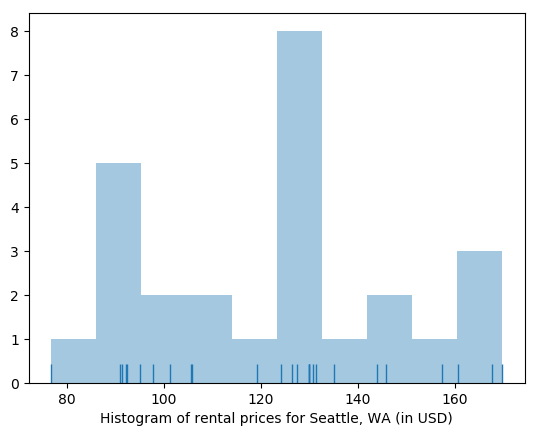

In [129]:
x = pd.Series(list(flats_dict.values()), name="Histogram of rental prices for Seattle, WA (in USD)")
sns.distplot(x, kde=False, rug=True, bins=10);

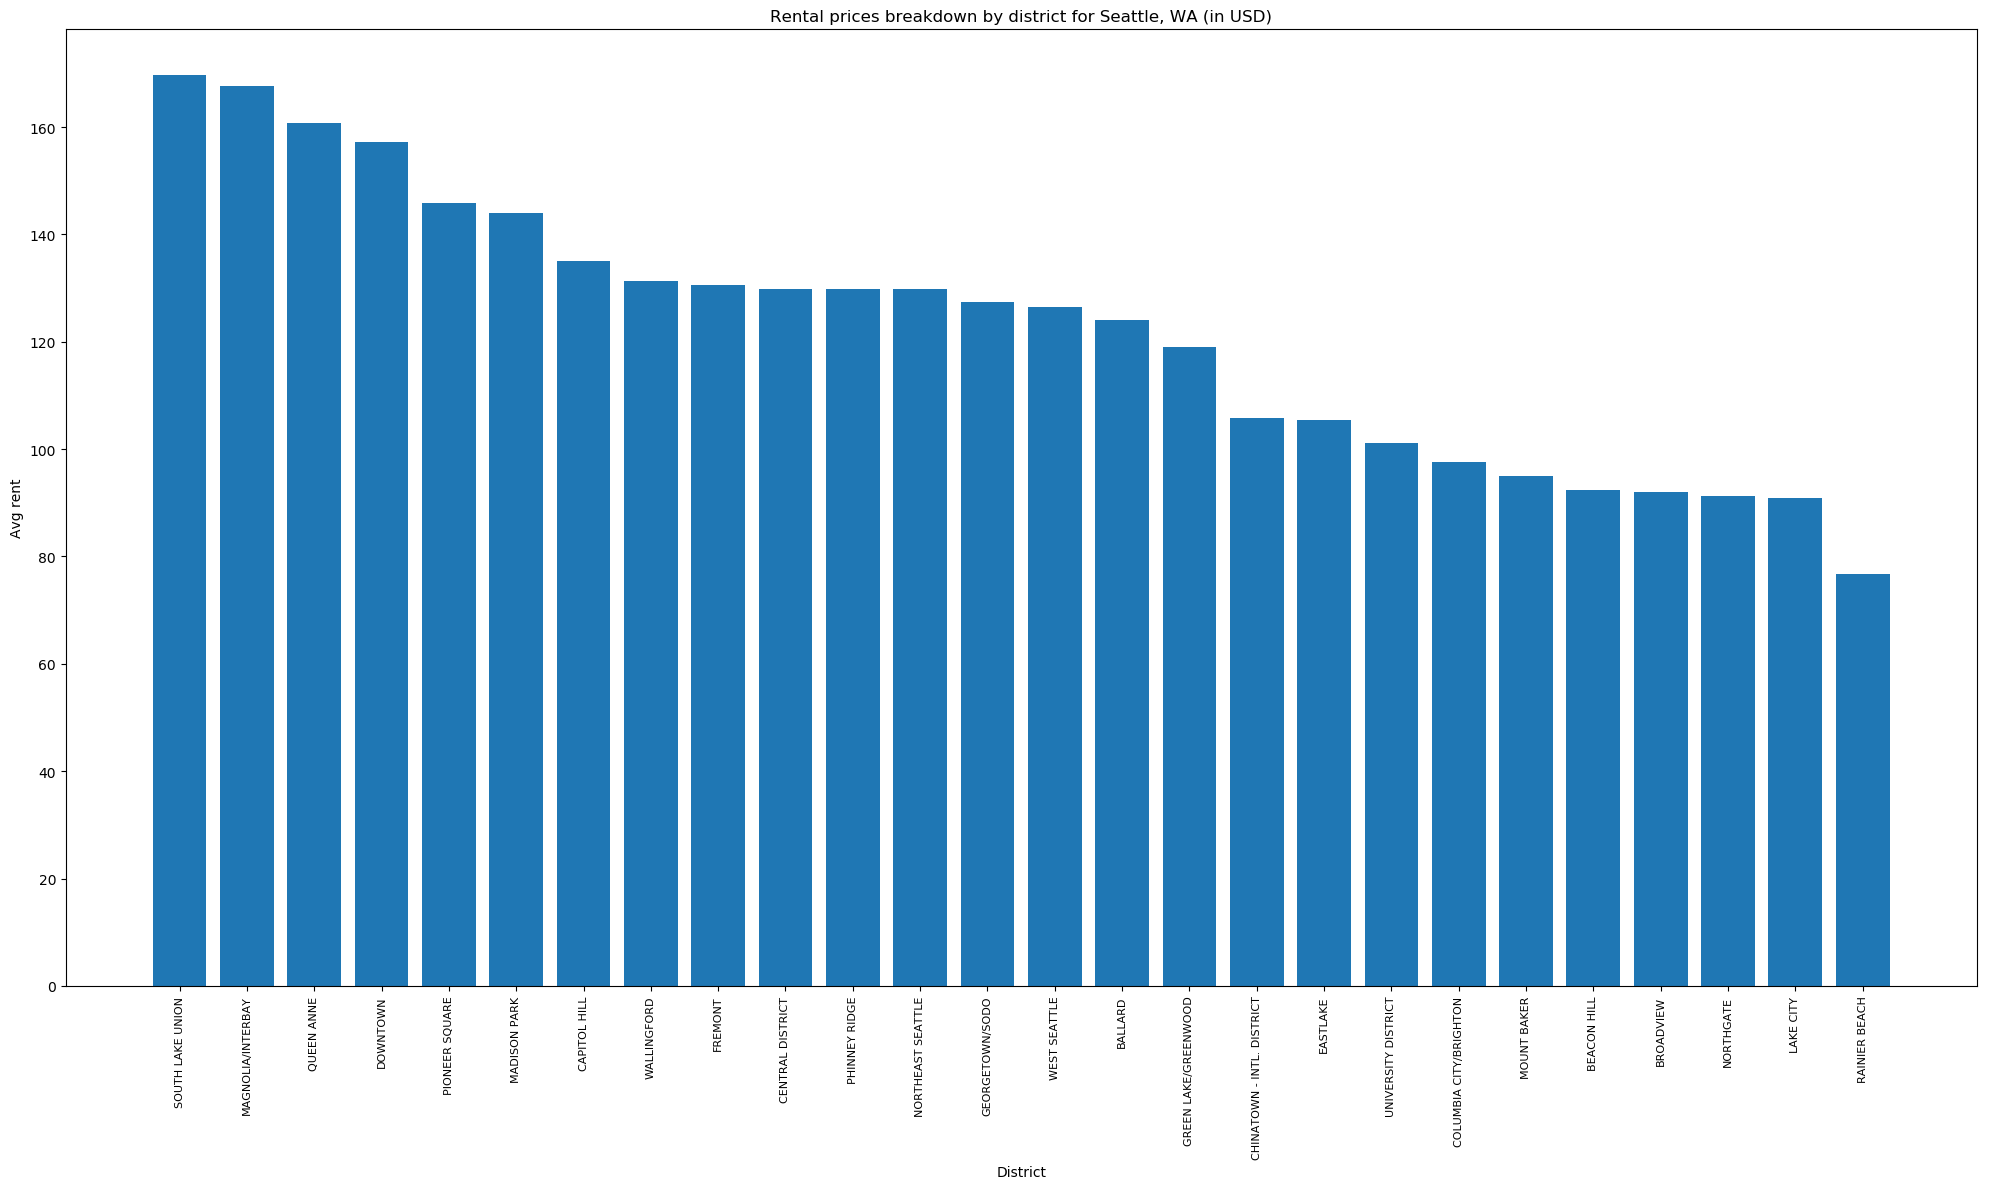

In [130]:
fig = plot_bar_chart(flats_dict, "Rental prices breakdown by district for Seattle, WA (in USD)", "District", "Avg rent")
plt.savefig("RentalPricesDistricts.png")
plt.show()

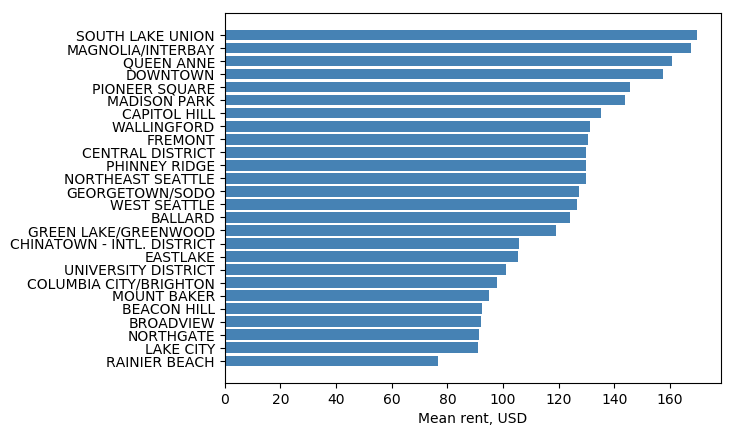

In [131]:
sorted_by_value = OrderedDict(sorted(flats_dict.items(), key=lambda x: -x[1]))

districts_ = sorted_by_value.keys()
y_pos_ = np.arange(len(districts_))
rent_ = list(sorted_by_value.values())
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y_pos_, rent_, align='center',
        color='#4682B4', ecolor='black')
ax.set_yticks(y_pos_)
ax.set_yticklabels(districts_)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mean rent, USD')
#ax.set_title('')
plt.savefig("RentDistricts.png")

In [132]:
x=pd.Series(list(crimes_rolling.values()), name="Rolling Crime Rate for Districts")
y=pd.Series(list(flats_dict.values()), name="Mean Rent for Districts")

E:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


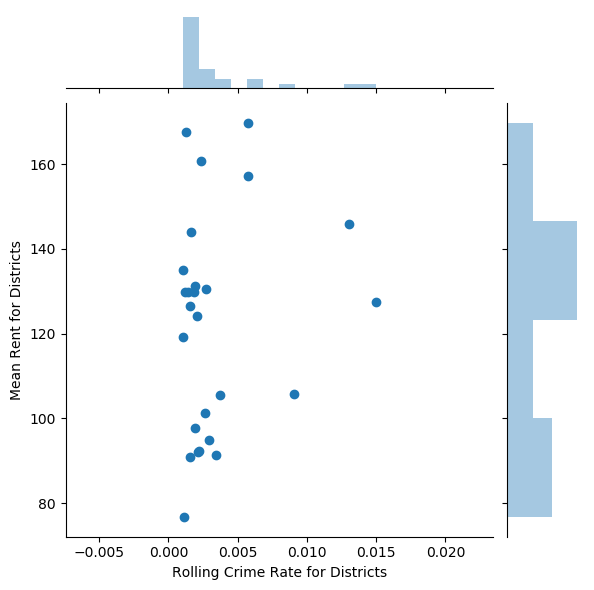

In [133]:
sns.jointplot(x=x, y=y);

Surprisingly, one can be paying $\$$170 per night in a district with higher crime rate than some with mean price of $\$$80 per night.

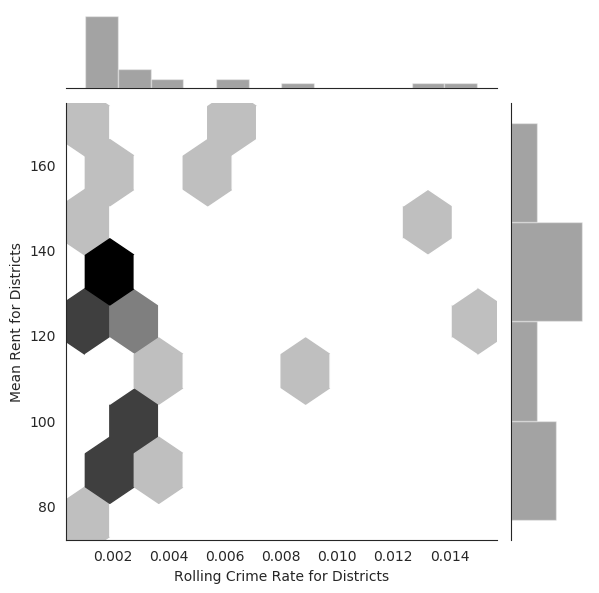

In [134]:
with sns.axes_style("white"):
    sns.jointplot(x=x, y=y, kind="hex", color="k");

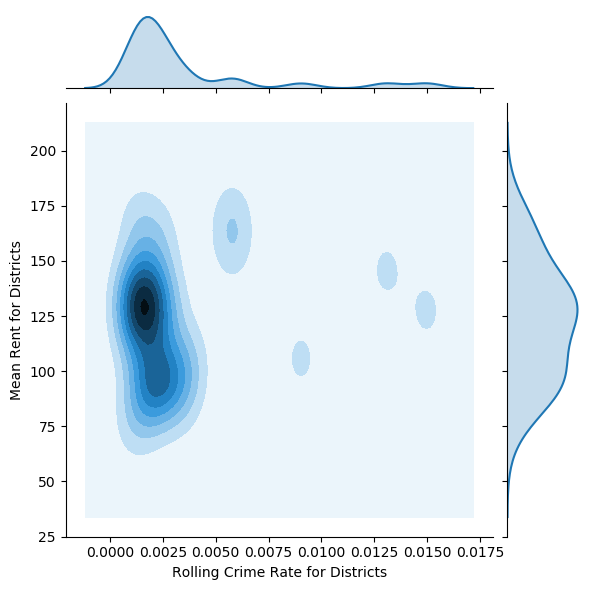

In [135]:
sns.jointplot(x=x, y=y, kind="kde")

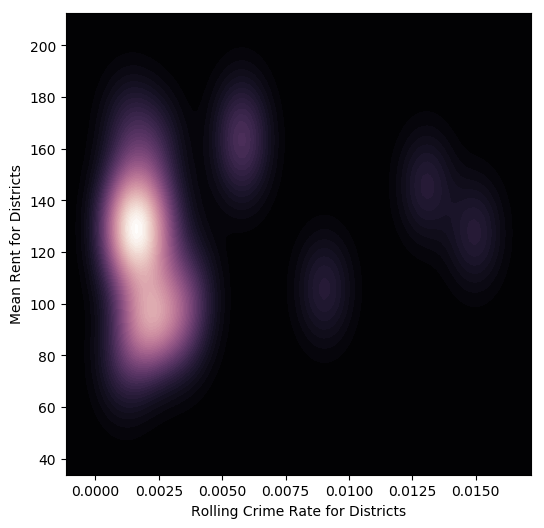

In [136]:
f, ax = plt.subplots(figsize=(6,6))
cmap = sns.cubehelix_palette(dark=0, light=1, reverse=True, as_cmap=True)
sns.kdeplot(x, y, cmap=cmap, n_levels=60, shade=True);

All in all there is only a slight positive correlation between mean rent and rolling crime rate:

In [137]:
np.corrcoef(x, y)[0, 1]

0.1776816722946841

In [138]:
from scipy.stats import linregress
linregress(x, y)

LinregressResult(slope=1278.0781839766062, intercept=117.7586740592256, rvalue=0.17768167229468407, pvalue=0.3851842594591516, stderr=1444.9176995456726)

Which is interesting: basically on average people pay higher rent to get into more troubles.

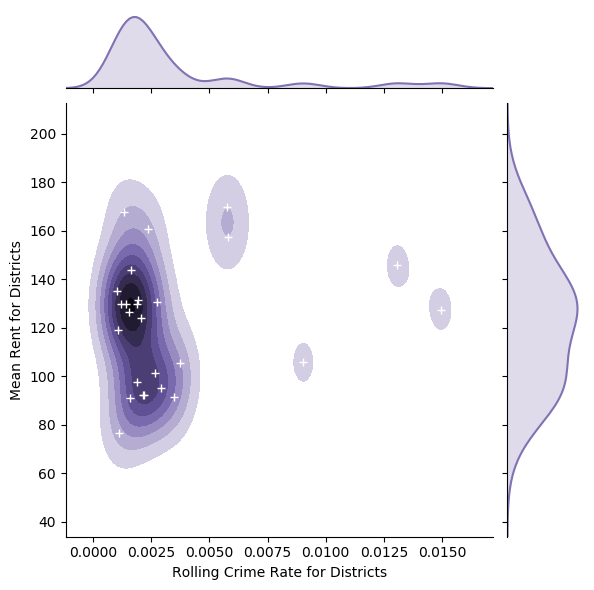

In [139]:
g = sns.jointplot(x=x, y=y, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
#g.set_axis_labels("", "$Y$");

In [140]:
ind = pd.Index(list(crimes_rolling.keys()), dtype='str')
combined = pd.DataFrame(data={'district' : list(crimes_rolling.keys()), 'crimes' : list(x), 'price' : list(y)}, index=ind)
combined.price = combined.price.astype(float)
combined.crimes = combined.crimes.astype(float)

In [141]:
combined

,district,crimes,price
BALLARD,BALLARD,0.002058,124.093750
BEACON HILL,BEACON HILL,0.002185,92.349515
BROADVIEW,BROADVIEW,0.002153,92.103448
CAPITOL HILL,CAPITOL HILL,0.001028,135.043561
CENTRAL DISTRICT,CENTRAL DISTRICT,0.001868,129.923304
CHINATOWN - INTL. DISTRICT,CHINATOWN - INTL. DISTRICT,0.009038,105.764706
COLUMBIA CITY/BRIGHTON,COLUMBIA CITY/BRIGHTON,0.001901,97.666667
DOWNTOWN,DOWNTOWN,0.005786,157.303483
EASTLAKE,EASTLAKE,0.003748,105.487805
FREMONT,FREMONT,0.002739,130.635135


In [142]:
np.argmax(combined['price'])

E:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


'SOUTH LAKE UNION'

In [143]:
np.argmin(combined['price'])

E:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


'RAINIER BEACH'

In [144]:
combined.loc['SOUTH LAKE UNION']['price'] / combined.loc['RAINIER BEACH']['price']

2.2122309262063062

In [145]:
combined.loc['SOUTH LAKE UNION']['crimes'] / combined.loc['RAINIER BEACH']['crimes']

5.169861464054711

So, to be more precise, comparing the most expensive district with the cheapest, one would pay 2.2 times higher rent on average for having 5.2 times higher chance of being involved in an aggravated assault, sex offense, rape, residential robbery, violence with weapons and other serious crimes.

### Choosing method for data analysis

## Context-based recommender

First method which was suggested to our client was context-based recommender, where we would be able to find districts similar to those preferred by the client. However, our clients have never been to Seattle and were unable to specify districts they’ve liked.

## K-Means clustering

Unsupervised learning techniques like k-means clustering were ruled out because they are too sensitive to the scaling of the datasets (remember that our data follows different distributions), difficulty to predict the number of clusters, order of the data having impact on the final result.

## Scoring engine

We have suggested to our client that for each of our data sources, we would create attribute groups. For crime rate: safe, normal, dangerous; for rental price: low, affordable, expensive; for proximity to parks: close, further, far.

Thus, for each apartment listed on Airbnb we compute each of these scores, then sum them up (potentially with some weights) to obtain an overall score, and then filter out those not meeting a desired minimum cut-off score.

This approach is easy for clients to understand, it is extendable to include other metrics, and the weights can be adjusted to prioritize different attributes.

For this case study, it has been agreed to assign scores between 0 and 10 according to the quantile of the attribute’s distribution. It has been agreed that criminality score is valued 1.5 times higher than score for proximity to parks and price score has weight of 1.25. And an apartment needs to acquire a total score of 24 to be of interest, and additionally, it’s price and parks score must each be at least 5, and criminality score at least 6 (our clients had concerns that we might end up with choosing apartments which are cheap and close to a park full of drug dealers).

Then, to compare districts to each other, we order them by ratio of desired apartment to the total number of listings.


### Reverse engineering the recommendations

For the purpose of this case study, we then try to use machine learning to reverse engineer which flats should be considered desired and which not: we use supervised learning on a fraction of the data set (training data) and then apply the learned criteria to the hidden part of the data set (test data).

### Feature Selection

Let us define the scores for each flat.

Compute 10 quantiles of the rent price distribution

In [168]:
price_quantiles = np.quantile(flats['price'], np.arange(0, 1, 0.1)) 
price_quantiles

array([ 20. ,  55. ,  69. ,  80. ,  95. , 100. , 120. , 144. , 170. ,
       229.2])

Bisect Python library can tell us the index of the position where a value should be inserted. 

In [169]:
import bisect
bisect.bisect_left(price_quantiles, 60)

2

By inverting this index, we obtain our desired score ranging from 0 to 10

In [170]:
def price_score(row):
    price=row['price']
    quantile_idx = bisect.bisect_left(price_quantiles, price)
    return 10 - quantile_idx

In [171]:
flats['price_score'] = flats.apply(lambda row: price_score(row), axis=1)

In [172]:
flats['price_score'].head()

0    6
1    2
2    0
3    5
4    0
Name: price_score, dtype: int64

As we can see, flats with prices $\$$85, $\$$150, $\$$975, $\$$100 and $\$$450 received scores 6, 2, 0, 5, 0 respectively. 
Looks rather reasonable.

In [173]:
crime_quantiles = np.quantile(list(crimes_rolling.values()), np.arange(0, 1, 0.1))

In [174]:
def criminality_score(row):
    crime_rate = crimes_rolling[row['neighbourhood']]
    quantile_idx = bisect.bisect_left(crime_quantiles, crime_rate)
    return 10 - quantile_idx

In [175]:
flats['criminality_score'] = flats.apply(lambda row: criminality_score(row), axis=1)



In [176]:
flats[["name", "latitude", "longitude", "price", "review_scores_rating", "neighbourhood", "weekly_price", "criminality_score", 'price_score']].head()

,name,latitude,longitude,price,review_scores_rating,neighbourhood,weekly_price,criminality_score,price_score
0,Stylish Queen Anne Apartment,47.636289,-122.371025,85.0,95.0,QUEEN ANNE,NaN,4,6
1,Bright & Airy Queen Anne Apartment,47.639123,-122.365666,150.0,96.0,QUEEN ANNE,"$1,000.00",4,2
2,New Modern House-Amazing water view,47.629724,-122.369483,975.0,97.0,QUEEN ANNE,NaN,4,0
3,Queen Anne Chateau,47.638473,-122.369279,100.0,NaN,QUEEN ANNE,$650.00,4,5
4,Charming craftsman 3 bdm house,47.632918,-122.372471,450.0,92.0,QUEEN ANNE,NaN,4,0


In [177]:
'''from geopy import distance

def proximity_to_park(row):
    lat = row['latitude']
    long = row['longitude']
    distances = []
    for index, row in seattle_parks.iterrows():
        distances.append(distance.distance((lat, long), 
            (row['venue.location.lat'], row['venue.location.lng'])).km)
    return min(distances)
flats['proximity_to_park'] = flats.apply(lambda row: proximity_to_park(row), axis=1)
'''

"from geopy import distance\n\ndef proximity_to_park(row):\n    lat = row['latitude']\n    long = row['longitude']\n    distances = []\n    for index, row in seattle_parks.iterrows():\n        distances.append(distance.distance((lat, long), \n            (row['venue.location.lat'], row['venue.location.lng'])).km)\n    return min(distances)\nflats['proximity_to_park'] = flats.apply(lambda row: proximity_to_park(row), axis=1)\n"

In [178]:
# proximity to parks takes very long time to compute, because our code isnt' exactly efficient.
# so we have computed that score once and save it into a CSV for future use.
# if you want to recompute it again, uncomment following lines

# flats['proximity_to_park'] = flats.apply(lambda row: proximity_to_park(row), axis=1)
#flats.to_csv('FlatsWithScores.csv')

flats=pd.read_csv('FlatsWithScores.csv')

In [179]:
flats[["name", "latitude", "longitude", "price", "review_scores_rating", "neighbourhood", "weekly_price", "criminality_score", 'price_score', 'proximity_to_park']].head()

,name,latitude,longitude,price,review_scores_rating,neighbourhood,weekly_price,criminality_score,price_score,proximity_to_park
0,Stylish Queen Anne Apartment,47.636289,-122.371025,85.0,95.0,QUEEN ANNE,NaN,4,6,0.201977
1,Bright & Airy Queen Anne Apartment,47.639123,-122.365666,150.0,96.0,QUEEN ANNE,"$1,000.00",4,2,0.539644
2,New Modern House-Amazing water view,47.629724,-122.369483,975.0,97.0,QUEEN ANNE,NaN,4,0,0.204806
3,Queen Anne Chateau,47.638473,-122.369279,100.0,NaN,QUEEN ANNE,$650.00,4,5,0.437227
4,Charming craftsman 3 bdm house,47.632918,-122.372471,450.0,92.0,QUEEN ANNE,NaN,4,0,0.339778


In [180]:
proximity_quantiles = np.quantile(flats['proximity_to_park'], np.arange(0, 1, 0.1)) 
proximity_quantiles

array([0.00541498, 0.09494623, 0.14188464, 0.18348069, 0.21956673,
       0.26083074, 0.30634305, 0.36305306, 0.4420006 , 0.55397526])

In [181]:
def proximity_score(row):
    proximity=row['proximity_to_park']
    quantile_idx = bisect.bisect_left(proximity_quantiles, proximity)
    return 10 - quantile_idx

In [182]:
flats['proximity_to_park_score'] = flats.apply(lambda row: proximity_score(row), axis=1)

In [183]:
flats[["name", "latitude", "longitude", "price", "neighbourhood", "weekly_price", "criminality_score", 'price_score', 'proximity_to_park_score']].head()

,name,latitude,longitude,price,neighbourhood,weekly_price,criminality_score,price_score,proximity_to_park_score
0,Stylish Queen Anne Apartment,47.636289,-122.371025,85.0,QUEEN ANNE,NaN,4,6,6
1,Bright & Airy Queen Anne Apartment,47.639123,-122.365666,150.0,QUEEN ANNE,"$1,000.00",4,2,1
2,New Modern House-Amazing water view,47.629724,-122.369483,975.0,QUEEN ANNE,NaN,4,0,6
3,Queen Anne Chateau,47.638473,-122.369279,100.0,QUEEN ANNE,$650.00,4,5,2
4,Charming craftsman 3 bdm house,47.632918,-122.372471,450.0,QUEEN ANNE,NaN,4,0,3


In [184]:
def overall_score(row):
    crime = row['criminality_score']
    price = row['price_score']
    parks = row['proximity_to_park_score']
    if crime < 6:
        return 0
    if price < 5:
        return 0
    if parks < 5:
        return 0
    return price * 1.25 + crime * 1.5 + parks

def title(row):
    return "crime=" + str(row['criminality_score']) + ", price=" + str(row['price_score']) + ", park=" + str(row['proximity_to_park_score']) + "," + str(row['name'])

def desired(row):
    if row['overall_score'] >= 24:
        return 1
    return 0

In [185]:
flats['overall_score'] = flats.apply(lambda row: overall_score(row), axis=1)
flats['desired'] = flats.apply(lambda row: desired(row), axis=1)
flats['title'] = flats.apply(lambda row: title(row), axis=1)

In [186]:
flats[["name", "title", "latitude", "longitude", "price", "criminality_score", 'price_score', 'proximity_to_park_score', 'overall_score', 'desired']].head()

,name,title,latitude,longitude,price,criminality_score,price_score,proximity_to_park_score,overall_score,desired
0,Stylish Queen Anne Apartment,"crime=4, price=6, park=6,Stylish Queen Anne Ap...",47.636289,-122.371025,85.0,4,6,6,0.0,0
1,Bright & Airy Queen Anne Apartment,"crime=4, price=2, park=1,Bright & Airy Queen A...",47.639123,-122.365666,150.0,4,2,1,0.0,0
2,New Modern House-Amazing water view,"crime=4, price=0, park=6,New Modern House-Amaz...",47.629724,-122.369483,975.0,4,0,6,0.0,0
3,Queen Anne Chateau,"crime=4, price=5, park=2,Queen Anne Chateau",47.638473,-122.369279,100.0,4,5,2,0.0,0
4,Charming craftsman 3 bdm house,"crime=4, price=0, park=3,Charming craftsman 3 ...",47.632918,-122.372471,450.0,4,0,3,0.0,0


In [187]:
flats.loc[flats['desired'] == 1][["name", "title", "neighbourhood", "price", "criminality_score", 'price_score', 'proximity_to_park_score', 'overall_score', 'desired']]

,name,title,neighbourhood,price,criminality_score,price_score,proximity_to_park_score,overall_score,desired
455,Greenlake Summer Home,"crime=9, price=5, park=7,Greenlake Summer Home",GREEN LAKE/GREENWOOD,100.0,9,5,7,26.75,1
456,Modern Studio Apartment Near Park,"crime=9, price=7, park=8,Modern Studio Apartme...",GREEN LAKE/GREENWOOD,74.0,9,7,8,30.25,1
460,Enjoy our Cozy Waterfront nook! MIL,"crime=9, price=6, park=7,Enjoy our Cozy Waterf...",GREEN LAKE/GREENWOOD,92.0,9,6,7,28.00,1
463,"Private Room, Bath, & Kitchenette","crime=9, price=9, park=5,Private Room, Bath, &...",GREEN LAKE/GREENWOOD,55.0,9,9,5,29.75,1
471,Cozy room by Green Lake!,"crime=9, price=9, park=5,Cozy room by Green Lake!",GREEN LAKE/GREENWOOD,40.0,9,9,5,29.75,1
483,Craftsman Home 1 block from Lake!,"crime=9, price=7, park=8,Craftsman Home 1 bloc...",GREEN LAKE/GREENWOOD,79.0,9,7,8,30.25,1
484,Cozy room at Green Lake Seattle.,"crime=9, price=8, park=8,Cozy room at Green La...",GREEN LAKE/GREENWOOD,59.0,9,8,8,31.50,1
488,Perfect Location 2BR Quiet St Shops,"crime=9, price=5, park=5,Perfect Location 2BR ...",GREEN LAKE/GREENWOOD,100.0,9,5,5,24.75,1
494,Bright GreenLake studio - all yours,"crime=9, price=6, park=7,Bright GreenLake stud...",GREEN LAKE/GREENWOOD,85.0,9,6,7,28.00,1
497,Greenlake Getaway,"crime=9, price=6, park=9,Greenlake Getaway",GREEN LAKE/GREENWOOD,90.0,9,6,9,30.00,1


In [188]:
y = flats.loc[flats['desired'] == 1]['latitude']

In [189]:
x = flats.loc[flats['desired'] == 1]['longitude']

In [190]:
titles = flats.loc[flats['desired'] == 1]['title']

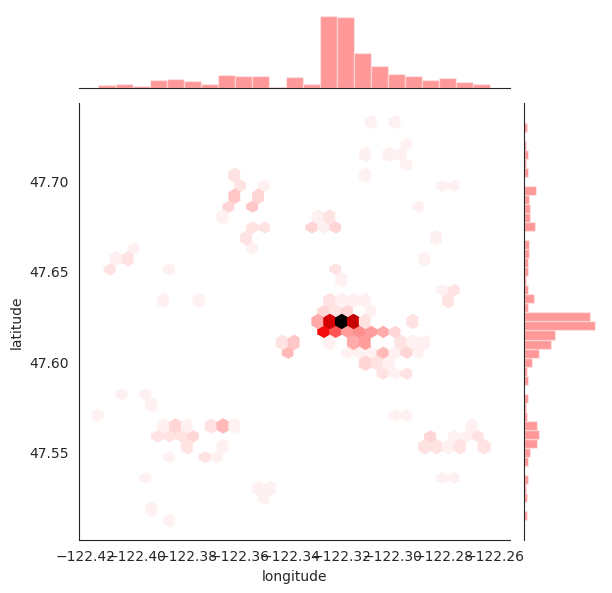

In [191]:
with sns.axes_style("white"):
    #plt.xticks(rotation=45)
    sns.jointplot(x=x, y=y, kind="hex", color="red");
    
    

In [192]:
len(x)

344

In [193]:
flats.shape

(3349, 101)

In [194]:
flats.to_csv('FlatsWithOverallScores.csv')

#### Only 344 appartments remained out of 3349, so 90% were filtered out.

## Model definition

As the next step, we will leverage machine learning to predict wheather a flat is desired or not based on the input features of rental price, proximity to parks and criminality score for its district.
Our target function is the value of 'desired' field. 
We use feed forward neural network to learn the relation between scores and quality of the flat.

In [199]:
flats[["name", 'price_score', 'proximity_to_park_score', 'criminality_score', 'desired']].to_csv('FlatsWithOverallScoresShort.csv')


In [200]:
import keras

In [201]:
from keras.utils import to_categorical

# Loading and pre-processing training dataset
train_data = flats[['price_score', 'proximity_to_park_score', 'criminality_score', 'desired']]
train_label = pd.DataFrame(train_data[["desired"]].copy(deep=False)) # Seperate labels (y) from inputs (X)
train_input = pd.DataFrame(train_data.drop("desired", 1, inplace=False))
del train_data

# Convert labels to dummies (one-hot encoding) so that they can be used in the output layer
#train_label = to_categorical(train_label)

print(train_input.describe())

       price_score  proximity_to_park_score  criminality_score
count  3349.000000              3349.000000        3349.000000
mean      4.558973                 4.500448           5.382502
std       2.899223                 2.873646           2.961875
min       0.000000                 0.000000           0.000000
25%       2.000000                 2.000000           3.000000
50%       5.000000                 5.000000           5.000000
75%       7.000000                 7.000000           7.000000
max      10.000000                10.000000          10.000000


In [202]:
print(train_label.describe())

           desired
count  3349.000000
mean      0.102717
std       0.303635
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


In [203]:
train_input.dtypes

price_score                int64
proximity_to_park_score    int64
criminality_score          int64
dtype: object

In [204]:
import pandas as pd
print(pd.DataFrame(train_label).describe())

           desired
count  3349.000000
mean      0.102717
std       0.303635
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


In [205]:
# Normalize the inputs
train_means = train_input.mean(axis=0) # Keep these for test too
train_stds  = train_input.std(axis=0)
print("Means:")
print(train_means.head(5))
print("Stds:")
print(train_stds.head(5))


Means:
price_score                4.558973
proximity_to_park_score    4.500448
criminality_score          5.382502
dtype: float64
Stds:
price_score                2.899223
proximity_to_park_score    2.873646
criminality_score          2.961875
dtype: float64


In [206]:
train_means.describe()

count    3.000000
mean     4.813974
std      0.493228
min      4.500448
25%      4.529710
50%      4.558973
75%      4.970738
max      5.382502
dtype: float64

In [207]:
train_stds.describe()

count    3.000000
mean     2.911581
std      0.045394
min      2.873646
25%      2.886435
50%      2.899223
75%      2.930549
max      2.961875
dtype: float64

In [208]:
train_means

price_score                4.558973
proximity_to_park_score    4.500448
criminality_score          5.382502
dtype: float64

In [209]:
train_input.head()

,price_score,proximity_to_park_score,criminality_score
0,6,6,4
1,2,1,4
2,0,6,4
3,5,2,4
4,0,3,4


In [210]:
train_input = train_input - train_means # Zero mean
train_input = train_input / train_stds # 1 standard deviation

In [211]:
train_input.head()

,price_score,proximity_to_park_score,criminality_score
0,0.497039,0.521829,-0.466766
1,-0.882641,-1.218121,-0.466766
2,-1.572481,0.521829,-0.466766
3,0.152119,-0.870131,-0.466766
4,-1.572481,-0.522141,-0.466766


In [214]:
X = train_input
y= train_label

###  Model training

In [215]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(2679, 3) (2679, 1)
(670, 3) (670, 1)


In [218]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

trains = {}
tests = {}
for units  in (10,15,20,25,30):
    for epochs in (1,3,8,15,30):
        model = Sequential()
        model.add(Dense(units=units, input_dim=X_train.shape[1],
                activation="relu"))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                  optimizer="RMSprop",
                  metrics=['accuracy'])
        model.fit(X_train.as_matrix(), y_train, epochs=epochs, batch_size=100)
        test_loss_and_metrics = model.evaluate(X_test.as_matrix(), y_test)
        train_loss_and_metrics = model.evaluate(X_train.as_matrix(), y_train)        
        trains[(units, epochs)] = train_loss_and_metrics[1]
        tests[(units, epochs)] = test_loss_and_metrics[1]

E:\anaconda\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Epoch 1/1
2679/2679 [==============================] - 1s 543us/step - loss: 0.5429 - acc: 0.7891


E:\anaconda\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


2679/2679 [==============================] - 0s 17us/step


E:\anaconda\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch 1/3
2679/2679 [==============================] - 2s 669us/step - loss: 0.9019 - acc: 0.3815
Epoch 2/3
2679/2679 [==============================] - 1s 249us/step - loss: 0.8017 - acc: 0.4505
Epoch 3/3
2679/2679 [==============================] - 0s 16us/step
Epoch 1/8
2679/2679 [==============================] - 2s 659us/step - loss: 0.6597 - acc: 0.6745
Epoch 2/8
2679/2679 [==============================] - 1s 394us/step - loss: 0.5797 - acc: 0.7846
Epoch 3/8
2679/2679 [==============================] - 1s 306us/step - loss: 0.5168 - acc: 0.8779
Epoch 4/8
2679/2679 [==============================] - 1s 520us/step - loss: 0.4623 - acc: 0.8966
Epoch 5/8
2679/2679 [==============================] - 1s 401us/step - loss: 0.4156 - acc: 0.8970
Epoch 6/8
2679/2679 [==============================] - 1s 331us/step - loss: 0.3761 - acc: 0.8970
Epoch 7/8
2679/2679 [==============================] - 1s 356us/step - loss: 0.3423 - acc: 0.8970
Epoch 8/8
2679/2679 [=============================

2679/2679 [==============================] - 0s 87us/step - loss: 0.3023 - acc: 0.9246
Epoch 9/15
2679/2679 [==============================] - 0s 76us/step - loss: 0.2745 - acc: 0.9332
Epoch 10/15
2679/2679 [==============================] - 0s 74us/step - loss: 0.2494 - acc: 0.9324
Epoch 11/15
2679/2679 [==============================] - 0s 90us/step - loss: 0.2271 - acc: 0.9365
Epoch 12/15
2679/2679 [==============================] - 0s 138us/step - loss: 0.2072 - acc: 0.9406
Epoch 13/15
2679/2679 [==============================] - 0s 84us/step - loss: 0.1892 - acc: 0.9522
Epoch 14/15
2679/2679 [==============================] - 0s 69us/step - loss: 0.1736 - acc: 0.9582
Epoch 15/15
2679/2679 [==============================] - 0s 17us/step
Epoch 1/30
2679/2679 [==============================] - 1s 531us/step - loss: 0.5612 - acc: 0.7178
Epoch 2/30
2679/2679 [==============================] - 0s 58us/step - loss: 0.4762 - acc: 0.8037
Epoch 3/30
2679/2679 [==============================

2679/2679 [==============================] - 0s 105us/step - loss: 0.2303 - acc: 0.9268
Epoch 13/30
2679/2679 [==============================] - 1s 228us/step - loss: 0.2069 - acc: 0.9373
Epoch 14/30
2679/2679 [==============================] - 2s 593us/step - loss: 0.1865 - acc: 0.9433
Epoch 15/30
2679/2679 [==============================] - 1s 339us/step - loss: 0.1685 - acc: 0.9477
Epoch 16/30
2679/2679 [==============================] - 0s 78us/step - loss: 0.1526 - acc: 0.9623
Epoch 17/30
2679/2679 [==============================] - 0s 76us/step - loss: 0.1388 - acc: 0.9672
Epoch 18/30
2679/2679 [==============================] - 1s 242us/step - loss: 0.1273 - acc: 0.9668
Epoch 19/30
2679/2679 [==============================] - 0s 46us/step - loss: 0.1175 - acc: 0.9664
Epoch 20/30
2679/2679 [==============================] - 0s 57us/step - loss: 0.1095 - acc: 0.9690
Epoch 21/30
2679/2679 [==============================] - 0s 54us/step - loss: 0.1028 - acc: 0.9713
Epoch 22/30
2679/

2679/2679 [==============================] - 0s 22us/step
Epoch 1/3
2679/2679 [==============================] - 2s 668us/step - loss: 0.5787 - acc: 0.8802
Epoch 2/3
2679/2679 [==============================] - 0s 25us/step - loss: 0.4729 - acc: 0.8970
Epoch 3/3
2679/2679 [==============================] - 0s 25us/step
Epoch 1/8
2679/2679 [==============================] - 2s 732us/step - loss: 0.6131 - acc: 0.7062
Epoch 2/8
2679/2679 [==============================] - 0s 69us/step - loss: 0.4788 - acc: 0.8421
Epoch 3/8
2679/2679 [==============================] - 0s 52us/step - loss: 0.3882 - acc: 0.8891
Epoch 4/8
2679/2679 [==============================] - 0s 66us/step - loss: 0.3211 - acc: 0.9026
Epoch 5/8
2679/2679 [==============================] - 0s 60us/step - loss: 0.2712 - acc: 0.9026
Epoch 6/8
2679/2679 [==============================] - 0s 63us/step - loss: 0.2334 - acc: 0.9078
Epoch 7/8
2679/2679 [==============================] - 0s 57us/step - loss: 0.2042 - acc: 0.9156

### Model Evaluation

In [219]:
trains

{(10, 1): 0.8309070547154788,
 (10, 3): 0.5837999255455176,
 (10, 8): 0.8969764839405887,
 (10, 15): 0.9324374766703994,
 (10, 30): 0.9667786487495335,
 (15, 1): 0.8342665171347344,
 (15, 3): 0.8958566631119212,
 (15, 8): 0.9227323628219485,
 (15, 15): 0.9637924598730869,
 (15, 30): 0.9843225083986562,
 (20, 1): 0.5871593877645338,
 (20, 3): 0.9134005226720487,
 (20, 8): 0.9104143337956023,
 (20, 15): 0.9499813364085176,
 (20, 30): 0.9805897723030982,
 (25, 1): 0.8118701006281327,
 (25, 3): 0.8969764839405887,
 (25, 8): 0.9029488616934815,
 (25, 15): 0.9746173945502054,
 (25, 30): 0.979843225172982,
 (30, 1): 0.8413587156940459,
 (30, 3): 0.8969764839405887,
 (30, 8): 0.9283314669652856,
 (30, 15): 0.9768570362075402,
 (30, 30): 0.986562150055991}

It can be seen, that for our simple use case, having 30 epochs reaches very good accuracy even for a small number of gates in the input layer (that's because the relationship between scores and the final outcome is linear).
In a more realistic case, we would need to introduce some dropout layers.
                                                                                                                                               

In [220]:
tests

{(10, 1): 0.8388059692596321,
 (10, 3): 0.5955223891272474,
 (10, 8): 0.8985074628644915,
 (10, 15): 0.9447761181575148,
 (10, 30): 0.9701492537313433,
 (15, 1): 0.8373134330137452,
 (15, 3): 0.9059701494316557,
 (15, 8): 0.9283582077097537,
 (15, 15): 0.9701492524858731,
 (15, 30): 0.9835820895522388,
 (20, 1): 0.5791044774340159,
 (20, 3): 0.9164179106256856,
 (20, 8): 0.9134328359988199,
 (20, 15): 0.9507462686567164,
 (20, 30): 0.982089552238806,
 (25, 1): 0.823880597370774,
 (25, 3): 0.8985074628644915,
 (25, 8): 0.9044776121182229,
 (25, 15): 0.9761194029850746,
 (25, 30): 0.9805970149253731,
 (30, 1): 0.8328358200059008,
 (30, 3): 0.8985074628644915,
 (30, 8): 0.9298507464465811,
 (30, 15): 0.9805970149253731,
 (30, 30): 0.9865671641791045}

Accuracy on the test case is very good too, which was expected.

The model with 30 input units and 30 epochs delivers the best accuracy and should be deployed to cloud (unfortunatelly, I've already exhaused all CPU time on IBM cloud by now).
                                                                                                        

In [222]:
from keras.models import load_model
model = Sequential()
model.add(Dense(units=units, input_dim=X_train.shape[1],
    activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
    optimizer="RMSprop",
    metrics=['accuracy'])


In [223]:
model.save('feed_forward.h5')

In [224]:
json_string = model.to_json()


In [225]:
json_string

'{"class_name": "Sequential", "config": {"name": "sequential_36", "layers": [{"class_name": "Dense", "config": {"name": "dense_69", "trainable": true, "batch_input_shape": [null, 3], "dtype": "float32", "units": 30, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_70", "trainable": true, "units": 1, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regulariz

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(units=500, input_dim=X_train.shape[1],
                activation="relu",
                 kernel_initializer="random_uniform",
                 bias_initializer="zeros"))
model.add(Dropout(0.30))
model.add(Dense(units=300, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.25))
model.add(Dense(units=200, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.20))
model.add(Dense(units=100, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.15))
model.add(Dense(units=50, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.10))
model.add(Dense(units=25, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.05))
model.add(Dense(units=2, activation="softmax"))

# Print out the network configuration
print(model.summary())

In [307]:
from keras.optimizers import RMSprop

# Train the network
model.compile(loss='categorical_crossentropy', 
              optimizer="RMSprop",#lr=0.0001),
              metrics=['accuracy'])
model.fit(X_train.as_matrix(), y_train, epochs=10, batch_size=60)

E:\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Epoch 1/10
2679/2679 [==============================] - 3s 1ms/step - loss: 0.2853 - acc: 0.8985A: 2s - loss: 0.3939
Epoch 2/10
2679/2679 [==============================] - 1s 500us/step - loss: 0.1062 - acc: 0.9731 2s - loss:
Epoch 3/10
2679/2679 [==============================] - 1s 504us/step - loss: 0.0694 - acc: 0.9791
Epoch 4/10
2679/2679 [==============================] - 2s 598us/step - loss: 0.0548 - acc: 0.9832
Epoch 5/10
2679/2679 [==============================] - 2s 888us/step - loss: 0.0454 - acc: 0.9839
Epoch 6/10
2679/2679 [==============================] - 2s 638us/step - loss: 0.0385 - acc: 0.9881
Epoch 7/10
2679/2679 [==============================] - 2s 723us/step - loss: 0.0322 - acc: 0.9914
Epoch 8/10
2679/2679 [==============================] - 2s 573us/step - loss: 0.0283 - acc: 0.9933
Epoch 9/10
2679/2679 [==============================] - 2s 583us/step - loss: 0.0239 - acc: 0.9951
Epoch 10/10
2679/2679 [==============================] - 2s 656us/step - loss: 0